# Functional Section
Run all the cells in Tarball Unzip first (shift+enter or click the left bracket region). Set the directory and file name (without extension). If the tarball hasn't been unzipped, use the buttons to navigate and do so. Then run all the cells before Post Processing, and set the settings at the last part. The images will start processing when you press the button there.

###Tarball Unzip

You may click on the first code cell and execute Shift+Enter down to the line displaying the options and a button to execute the calculation on the tar file specified tar files.

In [ ]:
import ipywidgets as widgets
import subprocess
import os
import logging

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Mumax Data"

/content/drive/MyDrive/Mumax Data


In [ ]:
global_directory = widgets.Text(value = '/content/drive/MyDrive/Mumax Data',
                                description='target directory', style= {'description_width': 'initial'})
move_button = widgets.Button(description='move to directory')
def move_trigger(trigger):
    print(global_directory.value)
    subprocess.run(['cd', global_directory.value], shell=True, check=True)
#tar_button.observe()
display(widgets.VBox(children=[global_directory, move_button]))

In [ ]:
!pwd

/content/drive/MyDrive/Mumax Data


In [ ]:
tar_filename = widgets.Text(description='tar file')
tar_button = widgets.Button(description='unzip tar.gz file')
def unzip_trigger(trigger):
    subprocess.run(['tar', 'xzf', tar_filename.value+'.tar.gz'])
tar_button.observe(unzip_trigger)
display(widgets.VBox(children=[tar_filename, tar_button]))

In [ ]:
!ls -l

total 1290529
-rw------- 1 root root     59690 May 25  2021  5-17-C_table.csv
-rw------- 1 root root  44286932 May 25  2021  5-17-D_combined.mp4
-rw------- 1 root root     59453 May 25  2021  5-17-E_table.csv
drwx------ 2 root root      4096 Jul 21  2021 '6-24-DMI_12 Analysis'
drwx------ 2 root root      4096 Jul 18  2021 '7-1-D_0 Analysis'
drwx------ 2 root root      4096 Jul 16  2021 '7-1-D_6 Analysis'
drwx------ 2 root root      4096 Jul 19  2021 '7-1-DMI_12 Analysis'
drwx------ 2 root root      4096 Jul 19  2021 '7-1-DMI_3 Analysis'
drwx------ 2 root root      4096 Jul 18  2021 '7-1-DMI_9 Analysis'
drwx------ 2 root root      4096 Aug  1  2021 '7-25-DMI_12 Analysis'
drwx------ 2 root root      4096 Aug  1  2021 '7-25-DMI_3 Analysis'
drwx------ 2 root root      4096 Aug  1  2021 '7-25-DMI_6 Analysis'
drwx------ 2 root root      4096 Aug  1  2021 '7-25-DMI_9 Analysis'
drwx------ 2 root root      4096 Oct  8  2021 'Analysis Videos'
-rw------- 1 root root      7583 Jun  8  2021  chiral

In [ ]:
!tar -xzf 'skyr_roll01_b1 (1).tar.gz'

In [ ]:
#!rm -r FeGd_10-18-wallscan05a_b1

Optional setting based on whether it's present in the data

In [ ]:
INCLUDE_ENERGY = False

In [ ]:
#####!mkdir FeGd_10-18-wallscan05a_b1 && tar -xzf "/content/drive/MyDrive/Mumax Data/FeGd_10-18-wallscan05_b1.tar.gz" -C "/content/drive/MyDrive/Mumax Data/FeGd_10-18-wallscan05a_b1"
#!ls FeGd_10-18-wallscan05_b1
#len(os.listdir('FeGd_10-18-wallscan05a_b1'))
#!tar -tf FeGd_10-18-wallscan05_b1.tar.gz
#22*14*200

###Imports

In [ ]:
!pip install parse
!pip install -U srt
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from parse import parse
from srt import Subtitle, compose
import ffmpeg

In [ ]:
#Imports
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False
from matplotlib import colors

import pandas as pd
from datetime import timedelta

import os
import shutil
import subprocess

### Core Functions
These define the basic functionality used by the main conversion function between magnetization png and chirality. Additional cells are a plot formatter, a plot maker and video functions for compiling converted images

In [ ]:
#
def boundary_filter(src_hsv,
                        low_h = 0,
                        high_h = 256,

                        low_s = 60,
                        high_s = 256,

                        low_v =  60,
                        high_v = 256):
    """applies filter on HSV image based on low and high limits"""
    #h_fil = (src_hsv[:,:,0] >= low_h) * (src_hsv[:,:,0] < high_h)
    #s_fil = (src_hsv[:,:,1] >= low_s) * (src_hsv[:,:,1] < high_s)
    #v_fil = (src_hsv[:,:,2] >= low_v) * (src_hsv[:,:,2] < high_v)
    #src_filter = h_fil * s_fil * v_fil
    src_filter = cv.inRange(src_hsv, (low_h, low_s, low_v), (high_h, high_s, high_v))
    return src_filter

def chirality_as_hsv(img_path, low_bound = 60):

    """converts chirality direction vector into hsv color space"""
    src = cv.imread(img_path, cv.IMREAD_COLOR)

    src_hsv = cv.cvtColor(src, cv.COLOR_BGR2HSV_FULL)
    #if use_blur:
    src = cv.GaussianBlur(src, (3, 3), 0)
    ###Magnetization Vector Info from Hue value
    #Converts the image to HSV space, with range 0-255 for all values due to the _FULL flag

    #Renormalizes Hue values as radians
    hsv_rad = np.float32(src_hsv[:,:,0])/255 * 2 * np.pi

    filter = boundary_filter(src_hsv, low_s=low_bound, low_v=low_bound)/255.0


    if np.count_nonzero(filter) == 0:
        return np.zeros_like(filter), filter

    #Gray determined by V term in HSV, this way all edge colors are equal
    gray = src_hsv[:,:,2]

    ddepth = cv.CV_64F
    scale = 1
    delta = 0
    #grad_x = cv.Scharr(gray,ddepth,1,0)
    grad_x = cv.Sobel(gray, ddepth, 1, 0, ksize=5, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    # Gradient-Y
    #grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv.Sobel(gray, ddepth, 0, 1, ksize=5, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)

    theta = -np.arctan2(grad_y, grad_x)

    total = np.mod(theta - hsv_rad, 2*np.pi)

    return total/(2*np.pi), filter

In [ ]:
#https://stackoverflow.com/questions/40642061/how-to-set-axis-ticks-in-multiples-of-pi-python-matplotlib
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

In [ ]:
def plot_4_chirality(df, predir, save=True):
    """creates a plot from the dataframe fields"""
    global INCLUDE_ENERGY

    df['time'] = df['time'] - df['time'].iloc[0]

    fig, ax = plt.subplots()

    # Twin the x-axis twice to make independent y-axes.
    axes = [ax, ax.twinx(), ax.twinx()] #, ax.twinx()]

    #old axis 0
    axes[0].set_ylim((0.0,1.0))
    axes[0].set_ylabel('Angle')    #axes[0].set_ylabel('chiral')



    #originally axis 3
    axes[0].set_yticks(np.linspace(0, 2*np.pi, 5))
    axes[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    axes[0].yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    # And finally we get to plot things...
    opacity = 0.2
    df.sort_values('frame', inplace=True)

    l7 = axes[0].plot(df['time'],df['angle'],marker='None',linestyle='-',color='red', label='angle')
    l5 = axes[1].plot(df['time'],df['field'],marker='None',linestyle='-',color='black', label='field', alpha = opacity)

    # Make some space on the right side for the extra y-axis.
    if INCLUDE_ENERGY:
        fig.subplots_adjust(right=0.75)
        axes[2].spines['right'].set_position(('axes', 1.2))
        axes[2].set_ylabel('Energy')
        #axes[2].set_ylim((-2.2785e-18, -2.278e-18))
        l6 = axes[2].plot(df['time'],df['energy'],marker='None',linestyle='-',color='orange', label='energy', alpha = opacity)

    # To make the border of the right-most axis visible, we need to turn the frame
    # on. This hides the other plots, however, so we need to turn its fill off.
    axes[-1].set_frame_on(True)
    axes[-1].patch.set_visible(False)

    axes[0].legend()

    if save:
        plt.savefig(fname=predir+'_chiral_mz_per_time.png')
    plt.show()


In [ ]:
#Make Video
#1. Chirality Video
def make_video_chiral(in_dir, out_dir, vid_name, filter_str="hsv_f_*.png"):
    """ffmpeg video conversion from images of chirality"""
    try:
        out, err = (
            ffmpeg
            .input(os.path.join(in_dir, filter_str),
                                pattern_type='glob',
                                framerate=1)
            .output(os.path.join(out_dir, vid_name),
                                video_bitrate=3000e3,
                                vcodec='libx264',
                                crf=0,
                                r=5)
            .overwrite_output()
            .run(capture_stdout=True,
                capture_stderr=True)
        )
        if out:
            print("SUCCESS")
            print(out)
        else:
            print("ERROR")
            print(err)
    except ffmpeg.Error as err:
        print(err.stderr)

def make_video_normal(in_dir, out_dir, vid_name, filter_str="m_*.png"):
    """ffmpeg video conversion from images of normal mumax images"""
    try:
        out, err = (
            ffmpeg
            .input(os.path.join(in_dir, filter_str),
                                pattern_type='glob',
                                framerate=1)
            .output(os.path.join(out_dir, vid_name),
                                video_bitrate=3000e3,
                                vcodec='libx264',
                                crf=0,
                                r=5)
            .overwrite_output()
            .run(capture_stdout=True,
                capture_stderr=True)
        )

        if out:
            print("SUCCESS")
            print(out)
        else:
            print("ERROR")
            print(err)
    except ffmpeg.Error as err:
        print(err.stderr)

def make_video_combo(in_dir, out_dir, vid_name, combo_name):
    """ffmpeg video conversion combining video streams from normal and chirality images"""
    try:

        left_side = ffmpeg.input(os.path.join(out_dir, vid_name))
        right_side = ffmpeg.input(os.path.join(in_dir, vid_name))
        out, err = (
            ffmpeg
            .filter_([left_side, right_side],'hstack', inputs=2)
            .output(os.path.join(out_dir, combo_name))
            .overwrite_output()
            .run(capture_stdout=True,
                capture_stderr=True)
        )
        if out:
            print("SUCCESS")
            print(out)
        else:
            print("ERROR")
            print(err)
    except ffmpeg.Error as err:
        print(err.stderr)

def make_video_hist(in_dir, out_dir, vid_name, filter_str="hist_f_*.png"):
    """ffmpeg video from generated histograms"""
    try:
        out, err = (
            ffmpeg
            .input(os.path.join(in_dir, filter_str),
                                pattern_type='glob',
                                framerate=1)
            .output(os.path.join(out_dir, vid_name),
                                video_bitrate=3000e3,
                                vcodec='libx264',
                                crf=0,
                                r=5)
            .overwrite_output()
            .run(capture_stdout=True,
                capture_stderr=True)
        )
        if out:
            print("SUCCESS")
            print(out)
        else:
            print("ERROR")
            print(err)
    except ffmpeg.Error as err:
        print(err.stderr)



##All in one Folder Run

###Utility Function(organize + pre_dirs)

In [ ]:
def organize(file_list, pre_dir, host_dir):
    os.makedirs(os.path.join(host_dir, pre_dir), exist_ok=True)
    for file in file_list:
        os.rename(os.path.join(host_dir, file), os.path.join(host_dir, pre_dir, file))

In [ ]:
def generate_pre_dirs(chirality = 'b1',
                      d_range = np.linspace(-1.2, 1.2, 25) * 1e-3,
                      B_range = np.linspace(.6, .78, 10),
                      format_string = "m_{}_d_{}_B_{:0.6f}_",
                      use_correction = True):
    """
    Identifies filenames by known DMI and B field values and chirality.
    This determines which filenames to use from the collected data.
    """
    pre_dirs = []

    for d in d_range:
        for B in B_range:
            ds = '{:0.6f}'.format(d)
            #print(d)
            if use_correction and d == 0:
                ds = '-'+ds

            p_dir = format_string.format(chirality,ds,B)
            print(p_dir)
            pre_dirs.append(p_dir)

    return pre_dirs


###dataframe and processed image function

In [ ]:
#from files
def df_and_vid_from_files(files, data,
                          pre_dir, file_dir,
                          threshold = 0.5,
                          low_bound = 120,
                          save_video = True,
                          save_histogram = True,
                          add_subs = True,
                          use_components=True):
    """Process chirality data per image across all images and saves image data"""

    df_chiral = pd.DataFrame(columns=['frame', 'field', 'b_1','b_2', 'n_1', 'n_2', 'angle', 'time', 'mz', 'energy'])

    print("file count: "+str(len(files)))
    print("data length: "+str(len(data)))

    subs = []

    framerate = 1.0
    frames = len(files)
    files.sort()
    #for i, file in enumerate(files):
    for i in range(len(files)):

        #fs = filter(lambda fname: ('m_%03d'%(i)) in fname, files)
        #file = next(fs)
        file = files[i]
        #print(file)

        raw_img, f = chirality_as_hsv(os.path.join(file_dir, file), low_bound=low_bound)

        result = np.stack((raw_img, np.ones_like(raw_img), np.ones_like(raw_img)), axis=-1)

        #Df segment
        #0 - ct, 1 - field, 2 - 3rd var type,4 - 3rd var value, 4 - state

        ind = i

        segment = data.iloc[ind]

        ###Swap for doing straight conversion only
        #ind = i
        #segment = data.loc[0]

        B_f = segment['B_extz (T)']
        #Add df entry
        t_1 = threshold * 0.25
        total = float(f.sum())
        #print(result.shape)
        #print(f.shape)
        raw_chiral = raw_img *(2*np.pi)
        total_angle = np.median(raw_chiral[f > 0])

        if use_components:

            raw_x = np.cos(raw_chiral)
            raw_y = np.sin(raw_chiral)
            b_1 = np.sum((raw_y > 0) * np.abs(raw_y) * (f>0))
            b_2 = np.sum((raw_y < 0) * np.abs(raw_y) * (f>0))

            n_1 = np.sum((raw_x < 0) * np.abs(raw_x) * (f>0))
            n_2 = np.sum((raw_x > 0) * np.abs(raw_x) * (f>0))
            #print(b_1, b_2, n_1,n_2)
            total = b_1 + b_2 + n_1 + n_2
            b_1 /= total
            b_2 /= total
            n_1 /= total
            n_2 /= total



        else:
            b_1 = ((raw_img <= (.5 - t_1)) & (raw_img >= t_1) & (f>0)).sum()/total
            b_2 = ((raw_img <= (1-t_1)) & (raw_img >= (0.5 + t_1)) & (f>0)).sum()/total
            n_1 = ((raw_img < (0.5+t_1)) & (raw_img > (0.5 - t_1)) & (f>0)).sum()/total
            n_2 = 1 - b_1 - b_2 - n_1

        df_chiral.loc[i] = [ind, float(B_f), b_1, b_2, n_1, n_2, total_angle, segment['# t (s)'],segment['mz ()'],segment['E_total (J)']]

        if save_video:
            #For Video
            inv_filter = 1 - f
            src = plt.imread(os.path.join(file_dir, file))
            combined = np.round(src*np.expand_dims(inv_filter, axis=-1)) + colors.hsv_to_rgb(result) * np.expand_dims(f, -1)

            #save video
            plt.imsave("hsv_f_{}{:04d}.png".format(pre_dir, ind), combined)
            #plt.imsave(file, combined)
        if save_histogram:
            plt.clf()
            X = np.ma.masked_array(raw_img, np.invert(f > 0))
            X = X.compressed()
            X = X.flatten()
            plt.xlim((0.0, 1.0))
            max_size = f.flatten().shape[0]
            plt.ylim((0.0, max_size/20.0))
            plt.xlabel('Chirality')
            plt.xlabel('Proportion')
            #hst, edges = np.histogram(X, bins=np.sqrt(max_size)/10.0, range=(0.0, 1.0))
            plt.hist(X, bins=np.sqrt(max_size)/5.0, range=(0.0, 1.0))
            #fig, ax = plt.subplots()
            #plt.stairs(hst, edges, fill=True)
            plt.savefig("hist_f_{}{:04d}.png".format(pre_dir, ind))
            #plt.clf()

        if add_subs:
            sub_str = "f={},B={},b1={:10.4f},b2={:10.4f},n1={:10.4f},n2={:10.4f}".format(ind, B_f, b_1, b_2, n_1, n_2)
            st = ind*(1.0/framerate)
            en = st + (1.0/framerate)
            subs.append(Subtitle(index=ind,
                                 start=timedelta(seconds=st),
                                 end=timedelta(seconds=en),
                                 content=sub_str))

    return df_chiral, subs


###Outer processing loop (directory, video, file manipulation) function

In [ ]:
def solo_operation(pre_dirs, host_dir, t_range=200,
                   make_subtitles=False, make_4_plot=True, make_videos=False, make_histogram=False,
                   initial_ct = 0, use_components=True, low_bound = 120):
    """Single Function that performs process steps and creates videos from saved images"""
    os.chdir(host_dir)
    V_dir = "vector frames"
    res_dir = "results"
    filename = 'table.txt'
    total_data = pd.read_csv(os.path.join(host_dir, filename), sep="\t", header=0)
    green_list = []
    purple_list = []
    ct = initial_ct

    #Make outer res dirs
    os.makedirs(os.path.join(V_dir, res_dir), exist_ok=True)
    os.makedirs(res_dir, exist_ok=True)

    for pre_dir in pre_dirs:

        print("Current pre-dir: "+pre_dir)
        file_dir = os.path.join(host_dir, pre_dir)
        vid_name = pre_dir + "_out.mp4"
        hist_vid_name = pre_dir + "_hist.mp4"
        #Complete directory structure
        #os.chdir(file_dir)

        os.chdir(host_dir)

        V_pre = os.path.join(host_dir, V_dir, pre_dir)
        os.makedirs(V_pre, exist_ok=True)

        #Make predir in result internal folders
        V_res = os.path.join(host_dir, V_dir, res_dir, pre_dir)
        os.makedirs(V_res, exist_ok=True)
        file_res = os.path.join(host_dir, res_dir, pre_dir)
        os.makedirs(file_res, exist_ok=True)

        #Loads table data csv
        #os.chdir(file_dir)

        #Move to result folder
        #os.chdir(os.path.join(host_dir, res_dir, pre_dir))
        file_list = [f for f in os.listdir(file_dir) if pre_dir in f and f.endswith('.png') and "(" not in f]
        file_ct = len(file_list)

        if file_ct == t_range:
            #Critical component

            data = total_data.iloc[ct*t_range:(ct+1)*t_range]
            ct += 1

            os.chdir(V_pre)

            df_chiral, subtitles = df_and_vid_from_files(file_list, data,
                                                         pre_dir, file_dir,
                                                         low_bound = low_bound,
                                                         save_video = make_videos,
                                                         save_histogram=make_histogram,
                                                         use_components=use_components)

            b_type, DMI, field = parse("m_{}_d_{:0.6f}_B_{:0.4f}_", pre_dir)

            green_list.append([DMI, field, df_chiral.loc[df_chiral['frame']==t_range-1]['b_1'].values[0]])
            purple_list.append([DMI, field, df_chiral.loc[df_chiral['frame']==t_range-1]['b_2'].values[0]])

            os.chdir(file_res)

            #Subs
            if make_subtitles:
                composed_subs = compose(subtitles)
                #print(type(composed_subs))
                with open(vid_name + "_subs.srt", "w") as text_file:
                    print(composed_subs, file=text_file)


            #Begin Generating plots
            data.plot.line(x='# t (s)', y=['mz ()', 'B_extz (T)']).figure.savefig('HvsT'+pre_dir+'.png')
            data.plot.line(x='B_extz (T)', y='mz ()', xticks=np.linspace(field-3*1e-4, field+3*1e-4, 7)).figure.savefig('HvsB'+pre_dir+'.png')

            #os.chdir(os.path.join(host_dir, res_dir))

            df_chiral.to_csv(os.path.join(file_res, pre_dir+"_table.csv"))

            #make 4 chirality plot
            if make_4_plot:
                #df = pd.read_csv(os.path.join(host_dir, res_dir, pre_dir+"_table.csv"))
                plot_4_chirality(df_chiral, pre_dir)

            print("Done with plots")

            os.chdir(V_res)
            #Video Section
            if make_videos:
                #Begin with the vector frames
                print("chirality video start")
                make_video_chiral(V_pre, V_res, vid_name, filter_str="hsv_f_{}*.png".format(pre_dir))

                #Change to Result directory
                os.chdir(file_res)

                print("normal video start")
                make_video_normal(file_dir, file_res, vid_name, filter_str="{}*.png".format(pre_dir))

                #os.chdir(os.path.join(host_dir, res_dir))

                print("combo video start")
                combo_vid = "combo_" + vid_name
                make_video_combo(V_res, file_res, vid_name, combo_vid)

            if make_histogram:

                print("hist video start")
                make_video_hist(in_dir=V_pre,out_dir=file_res, vid_name = hist_vid_name, filter_str="hist_f_{}*.png".format(pre_dir))
        else:
            print('File count: ', file_ct, 'Target count: ', t_range)
    os.chdir(file_res)
    green_df = pd.DataFrame(green_list, columns=['DMI', 'field', 'chirality'])
    purple_df = pd.DataFrame(purple_list, columns=['DMI', 'field', 'chirality'])

    green_df.to_csv('green_df.csv')
    purple_df.to_csv('purple_df.csv')




###processing function (create and organize data subdirectories)

In [ ]:
def identify_dirs(host_dir, chirality = 'b1',
                  d_range = np.linspace(-1.2, 1.2, 25) * 1e-3,
                  B_range = np.linspace(.6, .78, 10),
                  t_range = 200, ict=0,
                  low_bound = 120,
                  use_components=True,
                  make_videos=False, skip_organize = False,
                  use_correction = True,
                  pre_dirs = None):
    """Acquires all image file names and organizes images into subfolders if indicated to do so, assuming that it was not done before"""
    if pre_dirs is None:
        pre_dirs = generate_pre_dirs(chirality, d_range, B_range, use_correction = use_correction)

    if not skip_organize:
        for pre_dir in pre_dirs:

            if pre_dir in os.listdir(host_dir):
                ct = len(os.listdir(os.path.join(host_dir, pre_dir)))
                print('{} already converted, contains: {}'.format(pre_dir, ct))
                if ct != t_range:
                    file_list = [f for f in os.listdir(host_dir) if pre_dir in f and f.endswith('.png') and "(" not in f]
                    organize(file_list, pre_dir, host_dir)
            else:
                file_list = [f for f in os.listdir(host_dir) if pre_dir in f and f.endswith('.png') and "(" not in f]
                if len(file_list) != t_range:
                    print('!!!pre_dir: {} length: {} does not match t_range: {}'.format(pre_dir, len(file_list), t_range))
                #else:
                organize(file_list, pre_dir, host_dir)

    solo_operation(pre_dirs, host_dir, t_range=t_range, initial_ct=ict, make_videos=make_videos, low_bound=low_bound)





In [ ]:
'''
use_correction = False
pre_dirs = []
intercept = 0.0007
for d in np.arange(-.06, -0.01+1e-13, .01):
    B = (d/.01)*0.0001 + intercept
    for b in np.arange(B, B+0.0003+1e-13, 0.00006):
        ds = '{:0.6f}'.format(d*1e-3)
        #print(d)
        if use_correction and d == 0:
            ds = '-'+ds

        p_dir = "m_{}_d_{}_B_{:0.6f}_".format("b1",ds,b)
        print(p_dir)
        pre_dirs.append(p_dir)
'''
pass

###Navigate and run processing

In [ ]:
#%cd "/content/drive/MyDrive/Mumax Data"

In [ ]:
host_dir = os.path.join(global_directory.value, tar_filename.value)

In [ ]:
#host_dir = os.path.join("/content/drive/MyDrive/Mumax Data", "FeGd_4-22-wallroll01b_b1")

In [ ]:
%cd "$host_dir"

/content/drive/MyDrive/Mumax Data/skyr_roll01_b1


Run Step

*   DMI low, max, and skip indicate the minimum, maximum, and spacing between DMI values, same for the corresponding values for B
*   Chirality is to label the images initial chirality, as that is included in filenames
*   number of frames should be the number of images recorded for that combination of chirality, field, dmi
*   lower bound is already set at a good setting, but it can be adjusted to define what strictly is considered 'colorful' enough to be a domain wall rather than z-component magnetization
*   Use components indicates using the vector components rather than thresholding to determine the chirality
*   Negative zero correction is for common case where a negative is attached to the zero
*   Skip creating folders is in the case the images are organized before upload, you will probably want a modified .bashrc script to help with that



In [ ]:
#%cd "/content/drive/MyDrive/Mumax Data/FeGd_12-15-bubble_walls_e_b1"

m_b1_d_-0.002000_B_0.000000_
m_b1_d_-0.002000_B_0.000200_
m_b1_d_-0.002000_B_0.000400_
m_b1_d_-0.002000_B_0.000600_
m_b1_d_-0.002000_B_0.000800_
m_b1_d_-0.002000_B_0.001000_
m_b1_d_-0.002000_B_0.001200_
m_b1_d_-0.002000_B_0.001400_
m_b1_d_-0.002000_B_0.001600_
m_b1_d_-0.002000_B_0.001800_
m_b1_d_-0.002000_B_0.002000_
m_b1_d_-0.002000_B_0.002200_
m_b1_d_-0.002000_B_0.002400_
m_b1_d_-0.001800_B_0.000000_
m_b1_d_-0.001800_B_0.000200_
m_b1_d_-0.001800_B_0.000400_
m_b1_d_-0.001800_B_0.000600_
m_b1_d_-0.001800_B_0.000800_
m_b1_d_-0.001800_B_0.001000_
m_b1_d_-0.001800_B_0.001200_
m_b1_d_-0.001800_B_0.001400_
m_b1_d_-0.001800_B_0.001600_
m_b1_d_-0.001800_B_0.001800_
m_b1_d_-0.001800_B_0.002000_
m_b1_d_-0.001800_B_0.002200_
m_b1_d_-0.001800_B_0.002400_
m_b1_d_-0.001600_B_0.000000_
m_b1_d_-0.001600_B_0.000200_
m_b1_d_-0.001600_B_0.000400_
m_b1_d_-0.001600_B_0.000600_
m_b1_d_-0.001600_B_0.000800_
m_b1_d_-0.001600_B_0.001000_
m_b1_d_-0.001600_B_0.001200_
m_b1_d_-0.001600_B_0.001400_
m_b1_d_-0.0016

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


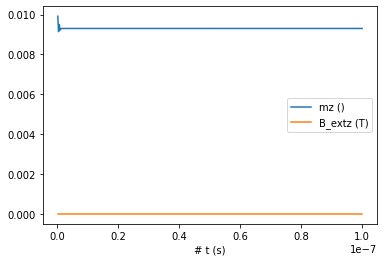

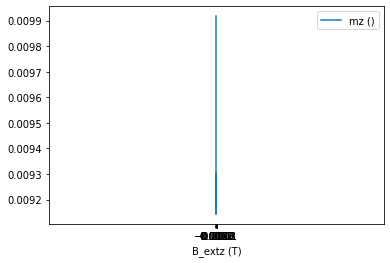

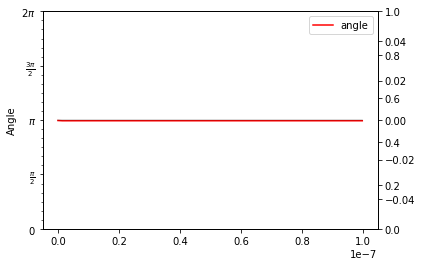

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


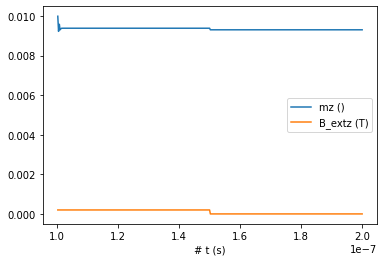

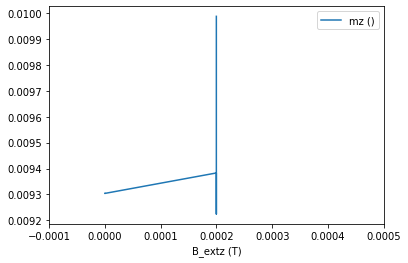

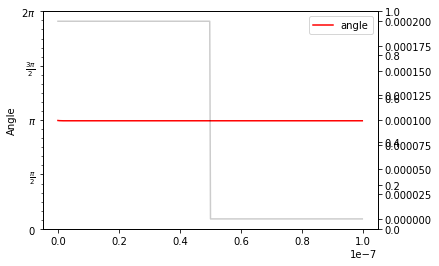

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


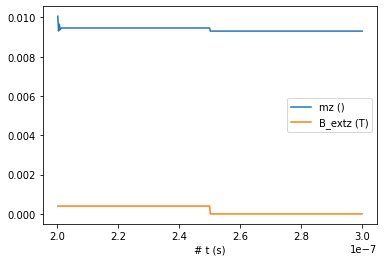

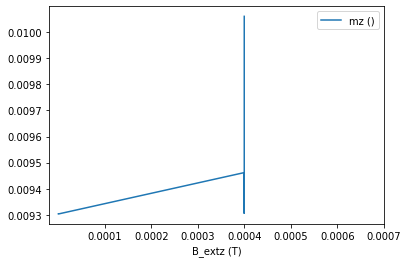

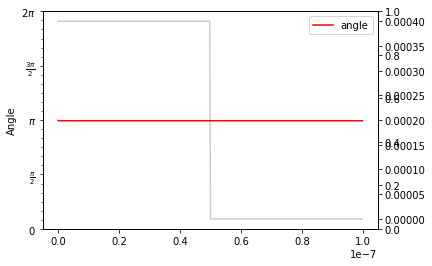

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


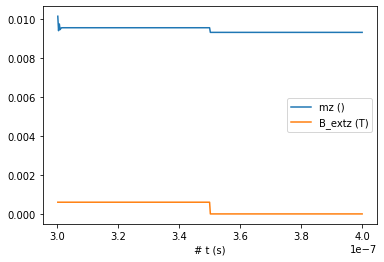

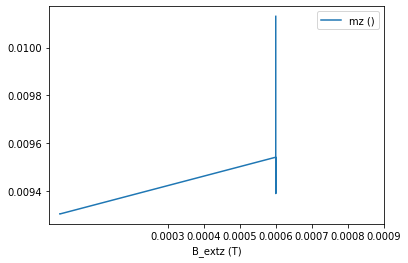

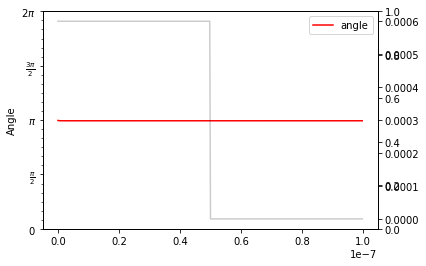

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


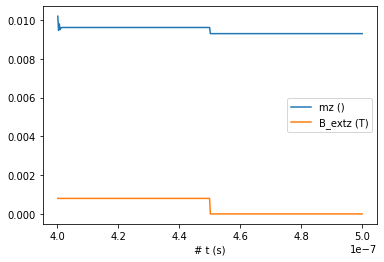

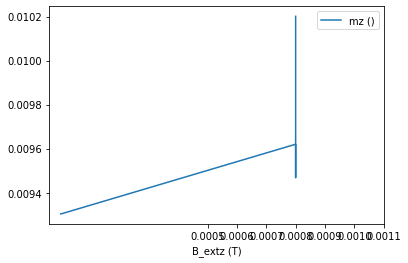

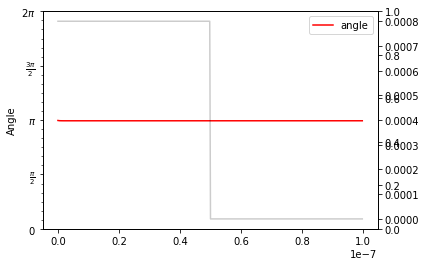

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


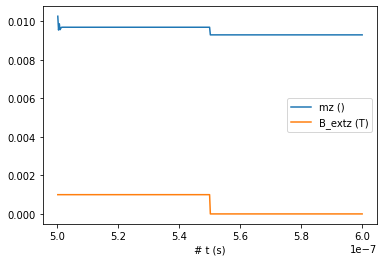

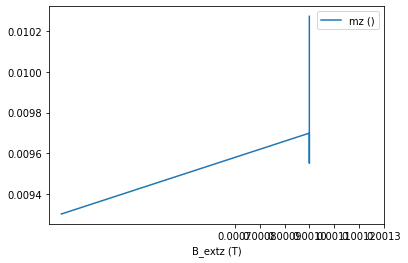

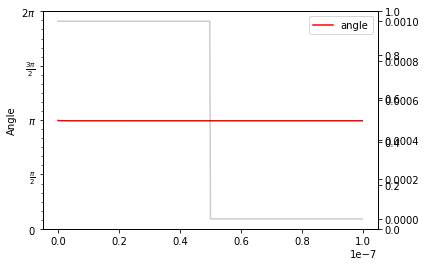

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


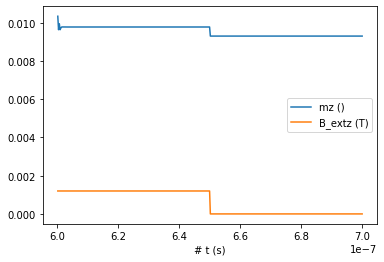

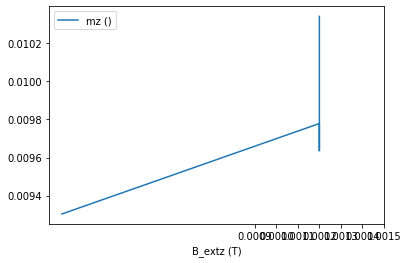

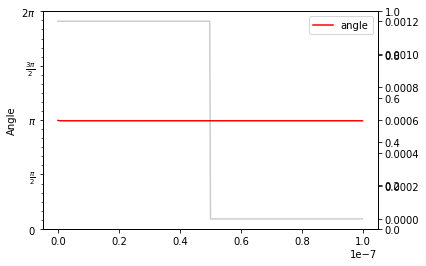

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


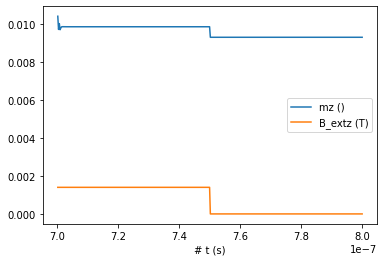

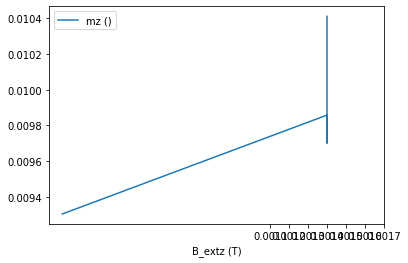

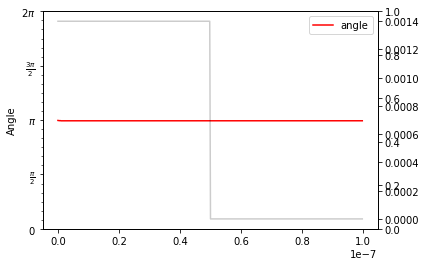

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


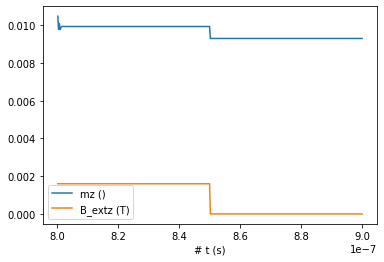

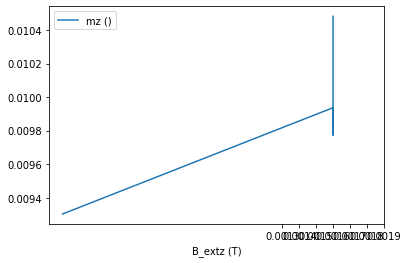

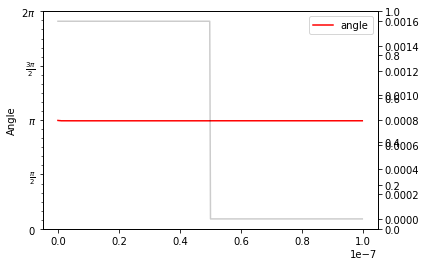

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


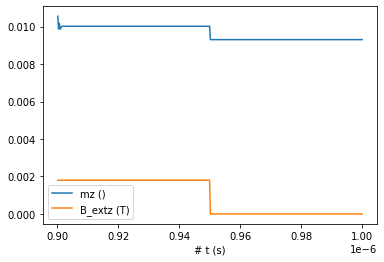

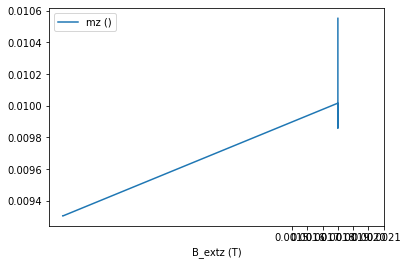

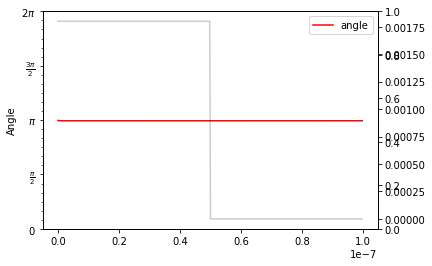

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


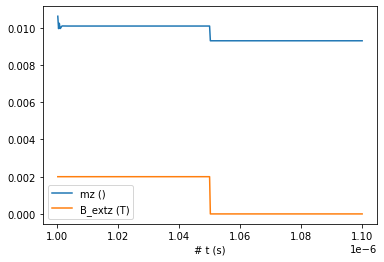

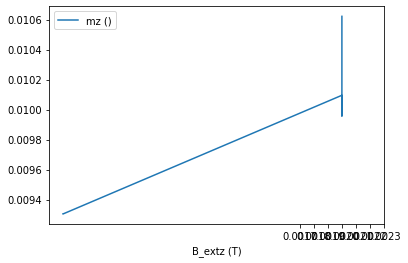

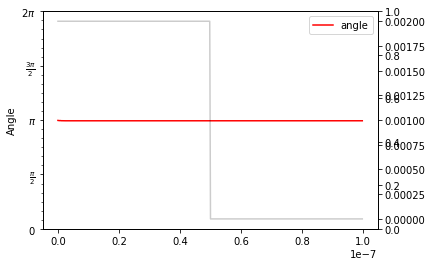

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


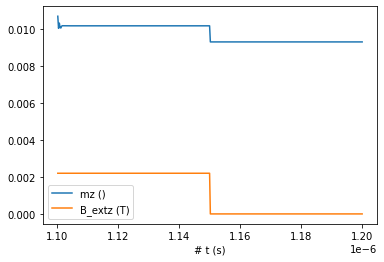

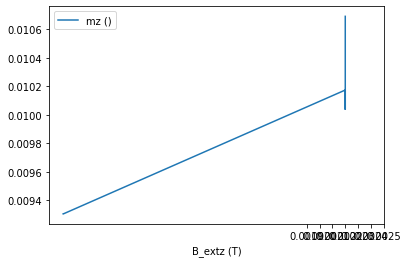

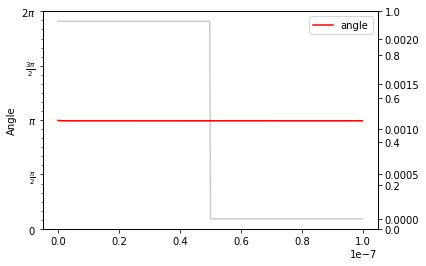

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


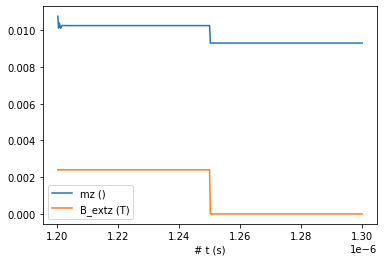

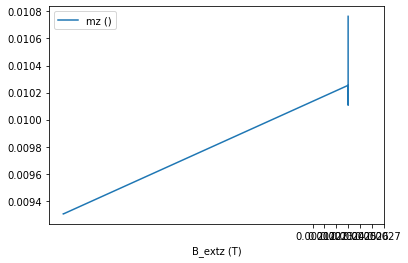

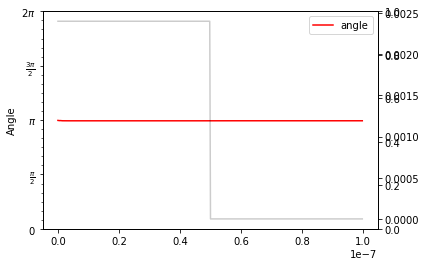

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


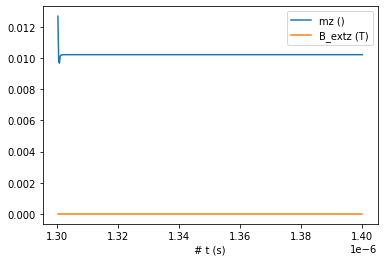

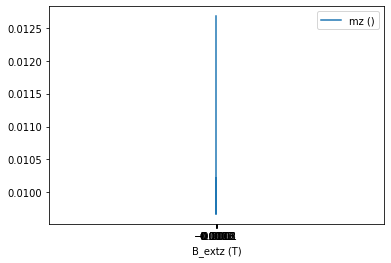

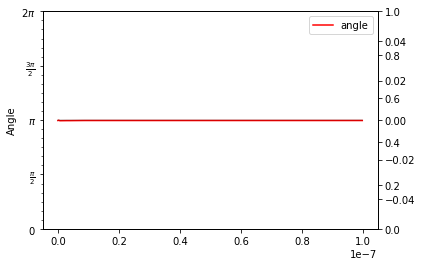

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


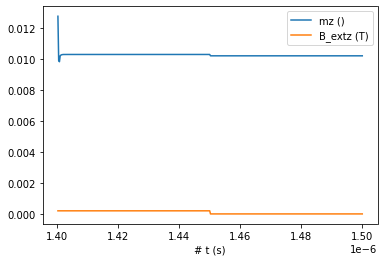

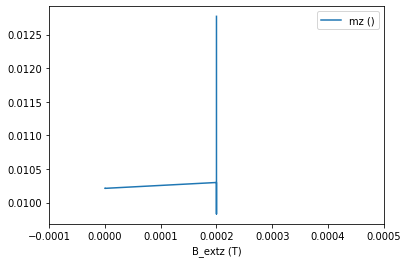

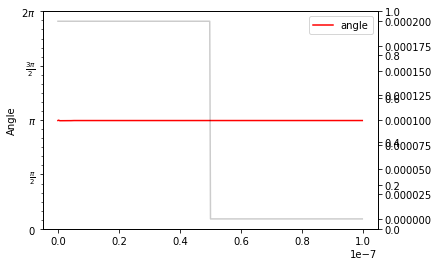

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


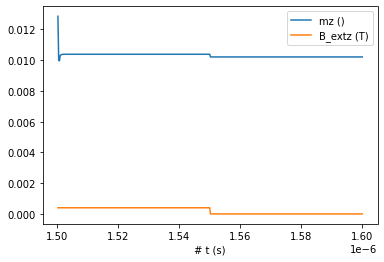

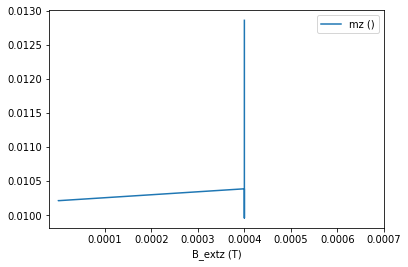

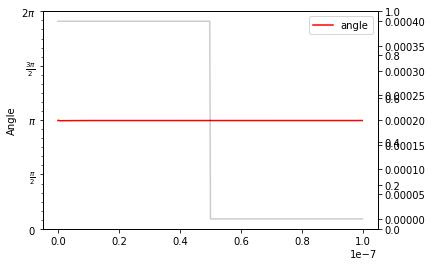

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


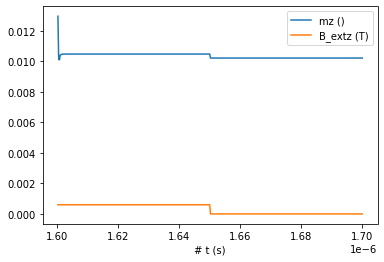

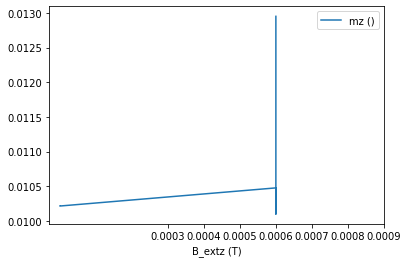

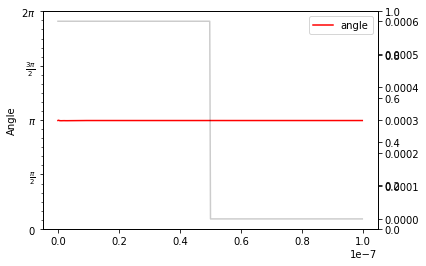

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


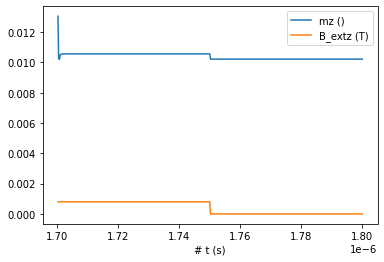

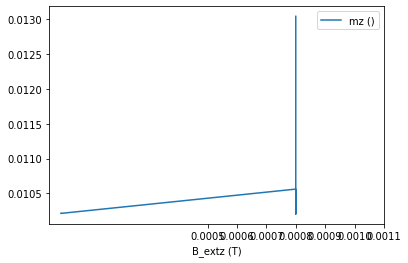

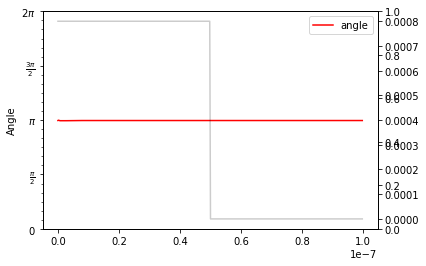

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


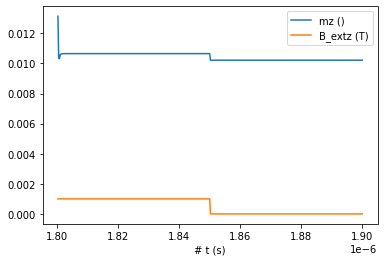

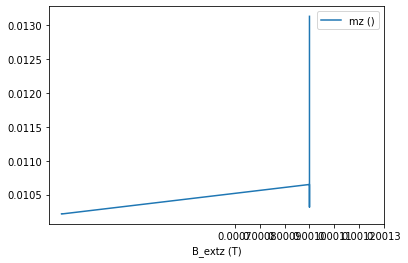

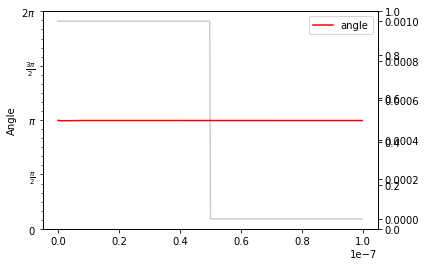

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


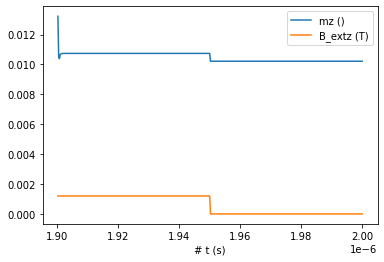

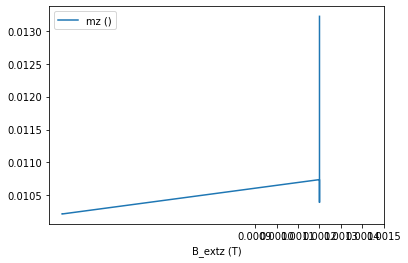

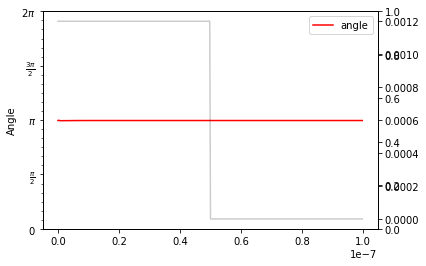

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


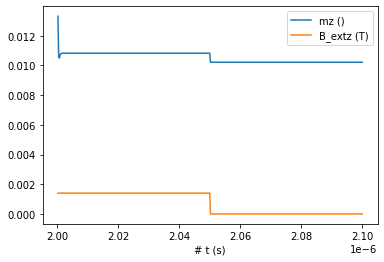

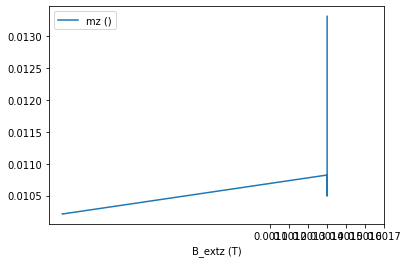

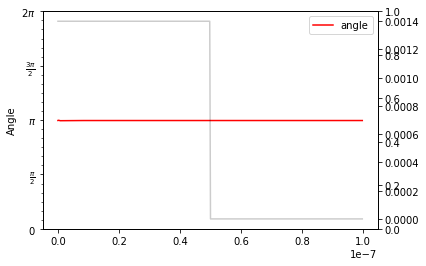

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


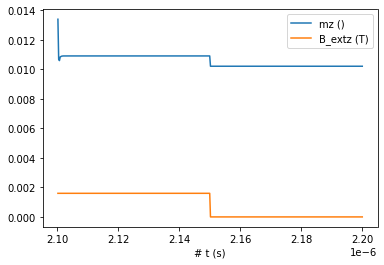

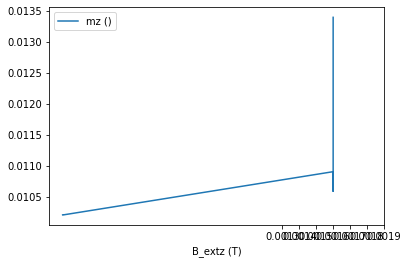

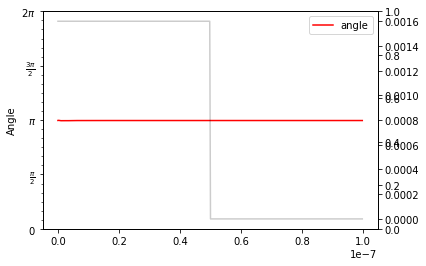

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


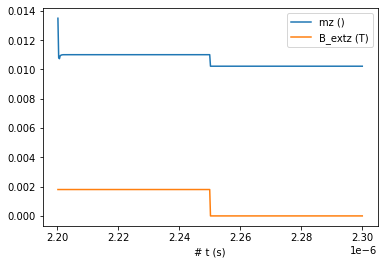

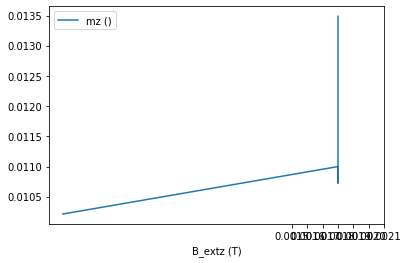

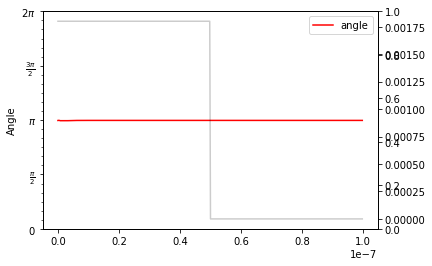

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


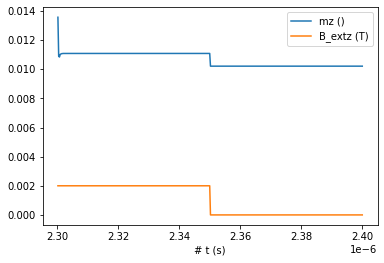

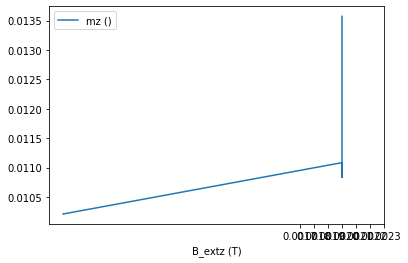

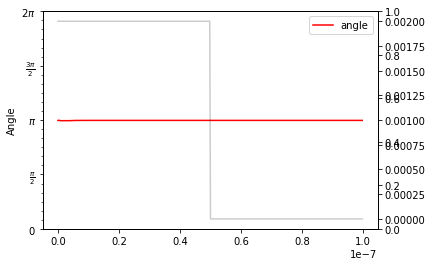

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


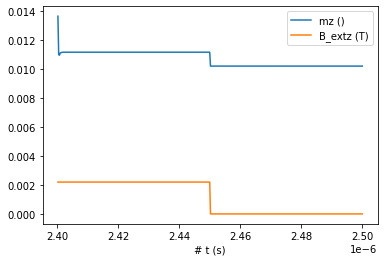

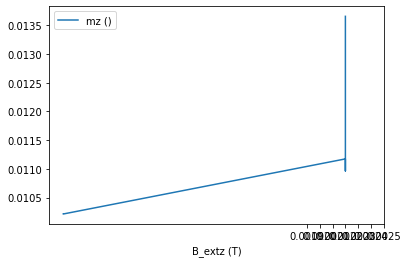

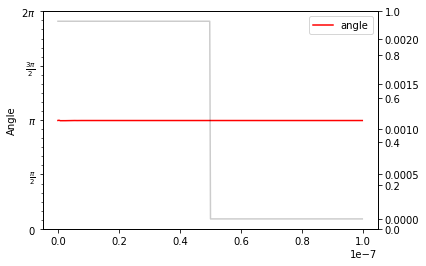

Done with plots
chirality video start
ERROR
b"ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

In [ ]:
chir = widgets.Dropdown(options=['b1', 'b2'], description='chirality')

d_min = widgets.FloatText(description='dmi low')
d_max = widgets.FloatText(description='dmi max')
d_skip = widgets.IntText(description='dmi skip')

B_min = widgets.FloatText(description='B low')
B_max = widgets.FloatText(description='B max')
B_skip = widgets.IntText(description='B skip')

t_frames = widgets.IntText(description='# of frames')
boundary = widgets.IntText(value =120, description='lower bound')

u_comp = widgets.Checkbox(value=True, description='Use Components')
u_videos = widgets.Checkbox(value=False, description='Make Videos')
u_corr = widgets.Checkbox(value=True, description='Use negative 0 correction')
u_skip = widgets.Checkbox(value=True, description='skip creating folders if it exists', style={'description-width':'initial'})

def calculation_trigger(trigger):

    identify_dirs(host_dir, chirality = chir.value,
                d_range = np.linspace(d_min.value, d_max.value, d_skip.value) * 1e-3,
                B_range = np.linspace(B_min.value, B_max.value, B_skip.value),
                t_range = t_frames.value, ict = 0,
                low_bound = boundary.value,
                use_components=u_comp.value,
                make_videos=u_videos.value,
                use_correction=u_corr.value,
                skip_organize = u_skip.value)

calculation_button = widgets.Button(description='do calculation')
calculation_button.on_click(calculation_trigger)

display(widgets.VBox(children=[chir, d_min, d_max, d_skip,
                               B_min, B_max, B_skip,
                               t_frames, boundary,
                               u_comp, u_videos, u_corr, u_skip,
                               calculation_button]))

Here's an example of how the parameters fit into the function, and obviously if more custom parameters are needed, there is the option to run the function itself instead

    identify_dirs(host_dir, chirality = 'b1',
                d_range = np.linspace(.00, .12, 13) * 1e-3,
                B_range = np.linspace(.000, .0021, 22),
                t_range = 400, ict = 0,
                low_bound = 120,
                use_components=True,
                make_videos=False,
                use_correction=True,
                skip_organize = True)

## Post Processing Steps

Below are cells that contain useful scripts for creating visualizations, note you should be familiar enough with linux+python to modify some commands to suit your setup

####Create Dataframe

Reload old csv files and recombine, then run needed plotting lines. Do this step for larger scans that had been broken down into smaller subsets of scans

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os

In [ ]:
%cd "/content/drive/MyDrive/Mumax Data"

/content/drive/MyDrive/Mumax Data


In [ ]:
#!mkdir temp

In [ ]:
#df_columns = ['DMI', 'field', 'b_1', 'b_2', 'n_1', 'n_2']
df_columns = ['DMI', 'field', 'b_1', 'b_2', 'n_1', 'n_2', 'angle', 'time']

In [ ]:
full_df = pd.DataFrame(columns=df_columns)

In [ ]:
def generate_pre_dirs(chirality = 'b1',
                      d_range = np.linspace(-1.2, 1.2, 25) * 1e-3,
                      B_range = np.linspace(.6, .78, 10),
                      format_string = "m_{}_d_{}_B_{:0.6f}_",
                      use_correction = True):

    pre_dirs = []

    for d in d_range:
        for B in B_range:
            ds = '{:0.6f}'.format(d)
            #print(d)
            if use_correction and d == 0:
                ds = '-'+ds

            p_dir = format_string.format(chirality,ds,B)
            #print(p_dir)
            pre_dirs.append(p_dir)

    return pre_dirs


In [ ]:
def append_df(full_df, host_dir, p_dirs = None, res_dir = "results", times = np.arange(200)):
    #t_frame = 100
    full_list = []
    if p_dirs is None:
        p_dirs = os.listdir(os.path.join(host_dir, res_dir))
    for pre_dir in p_dirs:
        #df_chiral.to_csv(os.path.join(file_res, pre_dir+"_table.csv"))

        os.chdir(os.path.join(host_dir, res_dir, pre_dir))

        #sect_dir = os.path.join(host_dir, res_dir, pre_dir)
        b_type, DMI, field = parse("m_{}_d_{:0.6f}_B_{:0.6f}_", pre_dir)

        df_path = os.path.join(host_dir, res_dir, pre_dir, pre_dir+"_table.csv")
        print(df_path)

        try:
            df_chiral = pd.read_csv(df_path)
            for t in times:
                tem = df_chiral.loc[df_chiral['frame']==t]
                full_list.append([DMI, field,
                                tem['b_1'].values[0], tem['b_2'].values[0], tem['n_1'].values[0], tem['n_2'].values[0],
                                tem['angle'].values[0], t
                                ])
        except Exception as err:
            print('file not found! '+pre_dir)

    return full_df.append(pd.DataFrame(full_list, columns=df_columns))


#### You'll need to change the parameters of p_dirs to match those used for creating the data, and change the number of frames collected for the times parameters below, and obviously the target path as well.

In [ ]:
p_dirs = generate_pre_dirs(chirality = 'b1',
                           d_range = np.linspace(.00, .12, 13) * 1e-3,
                           B_range = np.linspace(.0000, .0021, 22),
                           format_string = "m_{}_d_{}_B_{:0.6f}_",
                           use_correction=True)

In [ ]:
%cd "/content/drive/MyDrive/Mumax Data"

/content/drive/MyDrive/Mumax Data


In [ ]:
target = "FeGd_4-22-wallroll01b_b1"
host_dir = os.path.join("/content/drive/MyDrive/Mumax Data", target)

In [ ]:
#full_df = append_df(full_df, host_dir, p_dirs)
full_df = append_df(full_df, host_dir, p_dirs = p_dirs, times = np.arange(400))

#### Run these cells once the full df variable has all the others appended, remember to change the path name to something unique

In [ ]:
%cd "/content/drive/MyDrive/Mumax Data"

In [ ]:
full_df.to_csv("/content/drive/MyDrive/Mumax Data/4-22-wallroll_full.csv")

In [ ]:
#full_df

### Advanced Plotting section
Note that these are to be run after you have a complete csv of your data

#### Normalized plots

In [ ]:
full_df = pd.read_csv("/content/drive/MyDrive/Mumax Data/4-22-wallroll_full.csv")

several plot definition functions

In [ ]:
#https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot/6441839#6441839
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
def D_crit_and_Kd(A = 10.0e-12, Msat = 8e5, Ku = 12.0e5, tf = 1e-9):
    #A is exchange Stiffness
    #Ke is effective PMA
    mu_o = 1.256637062 * (10**(-6))
    Ke = Ku - (mu_o * (Msat ** 2))/2.0
    print(Ke)
    Lo = np.sqrt(A/Ke)

    Kd = (np.log(2) * tf * mu_o * Msat ** 2) / (2 * np.pi * Lo)

    #D_crit = (2 * np.log(2) * tf * mu_o * Msat ** 2) / (np.pi ** 2)

    return (4 * Lo * Kd)/np.pi, Kd

In [ ]:
def scaled_xy(x, y):
    """converts x and y values into their corresponding normalized units"""
    #x = np.unique(full_df['DMI'].values)
    #y = np.unique(full_df['field'].values)

    #if useNorm:
    Msat = 8.0e5
    norm_DMI, Kd = D_crit_and_Kd(A = 10.0e-12, Msat=Msat, Ku = 12.0e5, tf = 1e-9)
    alpha = 0.02
    #Kd/(8*Msat)

    bza_norm = Kd/(8.0*Msat) #using 8 does not match

    #x = np.unique(full_df['DMI'].values/norm_DMI)
    #y = np.unique((full_df['field'].values/alpha)/bza_norm)

    return (x/norm_DMI,(y/alpha)/bza_norm)

#else:



In [ ]:
def scaled_XY(x, y):
    """uses x and y values to form a colormap x and y variable base, and units are converted into normalized units"""
    useNorm = True

    #x = np.unique(full_df['DMI'].values)
    #y = np.unique(full_df['field'].values)

    if useNorm:
        Msat = 8.0e5
        norm_DMI, Kd = D_crit_and_Kd(A = 10.0e-12, Msat=Msat, Ku = 12.0e5, tf = 1e-9)
        alpha = 0.02
        #Kd/(8*Msat)

        bza_norm = Kd/(8.0*Msat) #using 8 does not match

        #x = np.unique(full_df['DMI'].values/norm_DMI)
        #y = np.unique((full_df['field'].values/alpha)/bza_norm)
        X, Y = np.meshgrid(x/norm_DMI,(y/alpha)/bza_norm)
    else:
        X, Y = np.meshgrid(x,y)

    return X, Y

#else:



In [ ]:
def plot_type_4(X, Y, Z, fig_name):
    #plt.clf()

    Z1, Z2, Z3, Z4 = Z[0], Z[1], Z[2], Z[3]

    figure_size = plt.gcf().get_size_inches()
    factor = 4.0
    plt.gcf().set_size_inches(factor * figure_size)

    #plt.gca().set_aspect('equal')

    fig, axes = plt.subplots(2, 2)
    #fig.set_figwidth(7)
    #fig.set_figheight(6)

    #ar = 0.01
    axes[0,0].set_title('Bloch CCW')
    axes[0,0].scatter(X,Y, c=Z1, marker="s", cmap="Greens")
    #axes[0,0].set_aspect(ar)
    axes[0,0].tick_params(which='both', size=5)

    axes[1,0].set_title('Bloch CW')
    axes[1,0].scatter(X,Y, c=Z2, marker="s", cmap="Purples")
    #axes[1].set_aspect(ar)
    axes[1,0].tick_params(which='both', size=5)

    axes[0,1].set_title('Neel Out')
    axes[0,1].scatter(X,Y, c=Z3, marker="s", cmap="Blues")
    #axes[0,1].set_aspect(ar)
    axes[0,1].tick_params(which='both', size=5)

    axes[1,1].set_title('Neel In')
    axes[1,1].scatter(X,Y, c=Z4, marker="s", cmap="Reds")
    #axes[1,1].set_aspect(ar)
    axes[1,1].tick_params(which='both', size=5)

    #plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    #plt.grid(False)
    #plt.xlabel("common X")
    #plt.ylabel("common Y")
    useNorm = True
    for ax in axes.flatten():
        #ax.set_aspect(1.0)
        #ax.set_adjustable(adjustable="datalim")
        if useNorm:
            ax.set_xlabel('D/Dc')
            ax.set_ylabel('bz/a')
        else:
            ax.set_xlabel('DMI (J)')
            ax.set_ylabel('Applied Field (Tesla)')

    plt.tight_layout()
    plt.savefig(fig_name+".png", format="png")
    plt.close(plt.gcf())

In [ ]:
def plot_type_p(X, Y, Z, fig_name):
    """plot chirality heatmap"""
    #plt.clf()

    ZA = Z[4]

    figure_size = plt.gcf().get_size_inches()
    #factor = (1.0, 0.6)
    #plt.gcf().set_size_inches(factor * figure_size)
    axes = plt.gca()

    #fig.set_figheight(3)

    axes.set_title('Angle')
    plotted = axes.scatter(X,Y, c=ZA, marker="s", cmap="hsv", vmin=0.0, vmax=2*np.pi)
    axes.tick_params(which='both', size=5)
    cb = plt.colorbar(plotted, format=plt.FuncFormatter(multiple_formatter()))
    cb.set_ticks(plt.MultipleLocator(np.pi / 2))
    #cb.set_ticklabels(['0, PI/2, PI, 3PI/2, 2PI'])
    #cb.set_label('angle')
    plt.savefig(fig_name+".png", format="png")
    plt.close(plt.gcf())
    #cb.ax.set_yticklabels()
    #set_major_locator(plt.MultipleLocator(np.pi / 2))
    #cb.ax.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    #cb.ax.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    #plt.tight_layout()

In [ ]:
def plot_type_2(X, Y, Z, fig_name):
    """plot chirality heatmap"""
    #plt.figure.clf()
    ZA = Z[4]

    figure_size = plt.gcf().get_size_inches()
    factor = (1.0, 0.6)
    plt.gcf().set_size_inches(factor * figure_size)

    axes = plt.gca()

    #fig.set_figwidth(3)

    axes.set_title('Angle')
    plotted = axes.scatter(X,Y, c=ZA, marker="s", cmap=newcmp, vmin=0.0, vmax=2*np.pi)
    axes.tick_params(which='both', size=5)
    cb = plt.colorbar(plotted, format=plt.FuncFormatter(multiple_formatter()))
    cb.set_ticks(plt.MultipleLocator(np.pi / 2))
    #plt.tight_layout()
    plt.savefig(fig_name+".png")
    plt.close(plt.gcf())

In [ ]:
def plot_type_compare(x, y, ZS, x_names, fig_name):

    #plt.figure.clf()

    #figure_size = plt.gcf().get_size_inches()
    #factor = (.3, 1.0)
    #plt.gcf().set_size_inches(factor * figure_size)

    fig, ax = plt.subplots()
    #axes = plt.gca()
    fig.set_figwidth(15)
    fig.set_figheight(30)

    if len(ZS.shape)> 2:
        ZS = np.hstack(ZS)
    ax.set_title('Angle')
    plotted = ax.imshow(ZS, cmap=newcmp, vmin=0.0, vmax=2*np.pi, origin='upper')
    cb = plt.colorbar(plotted, format=plt.FuncFormatter(multiple_formatter()))
    cb.set_ticks(plt.MultipleLocator(np.pi / 2))
    #plotted = axes.scatter(X,Y, c=Z, marker="s", cmap=newcmp, vmin=0.0, vmax=2*np.pi)
    #axes.scatter(X + offset, Y, c=Z2, marker="s", cmap=newcmp, vmin=0.0, vmax=2*np.pi)
    if x_names is not None:
        ax.set_xticks(np.arange(len(x_names)))
        ax.set_xticklabels(x_names)
    else:
        ax.set_xticks(np.arange(len(x)))
        ax.set_xticklabels(['%0.2f' % label for label in x])
    #x2, y2 = scaled_xy(x, y)
    ax.set_yticks(np.arange(len(y)))
    #print(y)
    ax.set_yticklabels(['%0.2f' % label for label in y])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #axes.tick_params(which='both', size=5)
    ax.invert_yaxis()

    plt.tight_layout()
    plt.savefig(fig_name+".png")
    plt.close(plt.gcf())

In [ ]:
def make_compare_plots(dfs, names, times, mask = None):
    """creates comparison plots between the first element in dfs and the matching element in the other dfs"""

    for t in times:
        t_df1 = dfs[0][dfs[0]['time']==t]

        if mask is not None:
            #print(t_df1)
            #t_df1 = t_df1[np.argwhere(npt_df1['DMI'])]
            #t_df1 = t_df1[t_df1['field'].is_in(mask[1])]

            dmi_indices = np.isin(t_df1['DMI'], mask[0])
            t_df1 = t_df1[dmi_indices]
            field_indices = np.isin(t_df1['field'], mask[1])
            t_df1= t_df1[field_indices]
            #print(t_df1)


        t_dfs = [df2[df2['time']==t] for df2 in dfs]

        x = np.unique(t_df1['DMI'].values)
        y = np.unique(t_df1['field'].values)

        x2, y2 = scaled_xy(x, y)

        #Z1 = np.zeros((len(y), len(x)))
        ZS = np.zeros((len(dfs), len(y), len(x)))

        for ind in range(len(t_df1)):
            b_df1 = t_df1.iloc[ind]
            b_dfs = [t_df2[(t_df2['field']==b_df1['field']) & (t_df2['DMI']==b_df1['DMI'])] for t_df2 in t_dfs]
            #b_df2 = b_df2[b_df2['DMI']==b_df1['DMI']]
            j = np.where(y == b_df1['field'])
            i = np.where(x == b_df1['DMI'])
            #print(b_df)
            #print(b_df2)
            #Z1[j,i] = b_df1['angle']
            #Z2[j,i] = b_df2['angle']
            ZS[:,j,i] = np.reshape([b_df2['angle'] for b_df2 in b_dfs],(-1, 1, 1))
        #print(y)
        #["thick", "thin"]
        fig_name = "p_t{:04d}".format(t)
        plot_type_compare(x2, y2, ZS, names, os.path.join("temp", fig_name))
        #make_video('/content/drive/MyDrive/Mumax Data/temp', '/content/drive/MyDrive/Mumax Data', plot_names[plotct]+"_out.mp4","p_t*.png")

In [ ]:
def make_linescan_plots(df, times, x, y):
    """creates plot of chirality heatmap"""
    for t in times:

        #x = np.unique(df['DMI'].values)
        #y = np.unique(df['field'].values)

        x2, y2 = scaled_xy(x, y)

        #Z1 = np.zeros((len(y), len(x)))
        ZS = -1 * (np.ones((len(y), len(x))))
        #print(ZS.shape)

        t_df = df[df['time']==t]

        for i, x_val in enumerate(x):
            for j, y_val in enumerate(y):
                #print(i, j)
                #print(x_val, y_val)
                l_df = t_df[(np.abs(t_df['DMI'] - x_val) < 1e-12) & (np.abs(t_df['field'] - y_val) < 1e-12)]
                if len(l_df) > 0:
                    #j = np.where(y_val == y)
                    #i = np.where(x_val == x)
                    #print(x_val, y_val)
                    #print(i, j)
                    ZS[j, i] = l_df['angle']
        #print(y)
        #["thick", "thin"]
        fig_name = "p_t{:04d}".format(t)
        plot_type_compare(x2, y2, ZS, None, os.path.join("temp", fig_name))
        #make_video('/content/drive/MyDrive/Mumax Data/temp', '/content/drive/MyDrive/Mumax Data', plot_names[plotct]+"_out.mp4","p_t*.png")

In [ ]:
def make_video(in_dir, out_dir, vid_name, filter_str="hsv_f_*.png"):
    try:
        out, err = (
            ffmpeg
            .input(os.path.join(in_dir, filter_str),
                                pattern_type='glob',
                                framerate=1)
            .output(os.path.join(out_dir, vid_name),
                                video_bitrate=3000e3,
                                vcodec='libx264',
                                crf=0,
                                r=5)
            .overwrite_output()
            .run(capture_stdout=True,
                capture_stderr=True)
        )
        if out:
            print("SUCCESS")
            print(out)
        else:
            print("ERROR")
            print(err)
    except ffmpeg.Error as err:
        print(err.stderr)

In [ ]:
def clear_folder(directory):
    files = os.listdir(directory)
    for file in files:
        os.remove(os.path.join(directory, file))

In [ ]:
def compare_plots(files, names=["thin","thick"], times=np.arange(0, 400, 1), dir="/content/drive/MyDrive/Mumax Data", mask=None):
    clear_folder('temp')
    dfs = [pd.read_csv(os.path.join(dir, file)) for file in files]
    make_compare_plots(dfs, names, times, mask)
    make_video('/content/drive/MyDrive/Mumax Data/temp', '/content/drive/MyDrive/Mumax Data', "comparison"+"_out.mp4",
                "p_t*.png")

In [ ]:
def make_plots(full_df, t_range = np.arange(200), plot_types = [plot_type_4, plot_type_2, plot_type_p], plot_names = ['plot_type_4', 'plot_type_2', 'plot_type_p']):
    """Takes a dataframe creates plots according to the plot types provided (number of plot names should match number of plot types)"""
    x = np.unique(full_df['DMI'].values)
    y = np.unique(full_df['field'].values)

    X, Y = scaled_XY(x, y)

    Z1 = np.zeros((len(y), len(x)))
    Z2 = np.zeros((len(y), len(x)))
    Z3 = np.zeros((len(y), len(x)))
    Z4 = np.zeros((len(y), len(x)))

    ZA = np.zeros((len(y), len(x)))
    for plotct, plot_type in enumerate(plot_types):
        clear_folder('temp')
        print('plot'+str(plotct))
        for t in t_range:
            t_df = full_df[full_df['time']==t]

            '''
            for i,d in enumerate(x):
                d_df = t_df[t_df['DMI']==d]
                for j,m in enumerate(y):
                    b_df = d_df[d_df['field']==m]
                    print(t, i, j)

            '''

            for ind in range(len(t_df)):
                b_df = t_df.iloc[ind]
                j = np.where(y == b_df['field'])
                i = np.where(x == b_df['DMI'])
                #print(b_df)
                Z1[j,i] = b_df['b_1']
                Z2[j,i] = b_df['b_2']
                Z3[j,i] = b_df['n_1']
                Z4[j,i] = b_df['n_2']
                ZA[j,i] = b_df['angle']

            Z = [Z1, Z2, Z3, Z4, ZA]
            fig_name = "p_t{:04d}".format(t)
            #for plotct, plot_type in enumerate(plot_types):
            plt.clf()
            plot_type(X, Y, Z, os.path.join("temp", fig_name))
        make_video('/content/drive/MyDrive/Mumax Data/temp', '/content/drive/MyDrive/Mumax Data', plot_names[plotct]+"_out.mp4",
                   "p_t*.png")


The cell below creates the colormap with purple and green bloch chirality and black and white neel chirality

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
PRGN = cm.get_cmap('PRGn', 512)
newcolors = np.vstack((PRGN(np.linspace(0.5, 1.0, 64)),
                      PRGN(np.linspace(1.0, 0.0, 128)),
                      PRGN(np.linspace(0.0, 0.5, 64))))
newcmp = ListedColormap(newcolors)

In [ ]:
import matplotlib.colors

#https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    #c1=np.array(colors.to_rgb(c1))
    #c2=np.array(colors.to_rgb(c2))

    return ((1-mix)*np.array(c1)[np.newaxis,:] + mix*c2)


In [ ]:
newcolors2 = newcolors.copy()
g_color = newcolors[63]
p_color = newcolors[-64]
#g_color
newcolors2[:64] = colorFader(np.array([0, 0, 0, 1]), g_color, mix=np.expand_dims(np.linspace(0,1,64),1))
newcolors2[-64:] = colorFader(p_color, np.array([0, 0, 0, 1]), mix=np.expand_dims(np.linspace(0,1,64),1))

In [ ]:
newcmp = ListedColormap(newcolors2)

In [ ]:
%cd '/content/drive/MyDrive/Mumax Data'

/content/drive/MyDrive/Mumax Data


### Plot Execution
Some examples of running the plotting functions, \\
for example plot_type_2 creates a heatmap, which is most likely used \\
If you have multiple 1d plots to compare, the compare plots function can be used \\
Further below, the Draw Grid section creates a panel of each chirality angle plot in a corresponding DMI and field position, but you will have to restart the kernel after upgrading matplotlib


In [ ]:
make_plots(full_df, t_range=np.arange(0, 400, 1), plot_types = [plot_type_2], plot_names = ['plot_type_2'])

plot0
ERROR
b"ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libx

In [ ]:
compare_plots(["1-11-thin_wall_d_b1_full.csv","12-15-thin_wall_b_b1_full.csv",
               "1-11-thick_wall_g_b1_full.csv","12-15-thick_wall_f_b1_full.csv"],
              names=["thin60","thin50","thick60x60","thick50x20"],
              times= np.arange(0, 400, 1),
              dir="/content/drive/MyDrive/Mumax Data",
              mask=[[-0.00004],[0.0004,0.001,0.0016]])

ERROR
b"ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --

In [ ]:
#!rm *.png

In [ ]:
compare_plots(["1-11-linescan01_b1_full.csv"])

In [ ]:
df = pd.read_csv(os.path.join('/content/drive/MyDrive/Mumax Data','1-11_linescan01_b1_full.csv'))

In [ ]:
df['DMI'].unique()

array([-1.2e-04, -1.1e-04, -1.0e-04, -9.0e-05, -8.0e-05, -7.0e-05,
       -6.0e-05, -5.0e-05, -4.0e-05, -3.0e-05, -2.0e-05, -1.0e-05,
       -0.0e+00,  1.0e-05,  2.0e-05,  3.0e-05,  4.0e-05,  5.0e-05,
        6.0e-05,  7.0e-05,  8.0e-05,  9.0e-05,  1.0e-04,  1.1e-04,
        1.2e-04])

In [ ]:
len(df['field'].unique())

51

In [ ]:
df['field'].unique()

In [ ]:
dmis = np.linspace(-.12, .12, 25)*1e-3
dmis[dmis==0] = -0.0
dmis

array([-1.2e-04, -1.1e-04, -1.0e-04, -9.0e-05, -8.0e-05, -7.0e-05,
       -6.0e-05, -5.0e-05, -4.0e-05, -3.0e-05, -2.0e-05, -1.0e-05,
       -0.0e+00,  1.0e-05,  2.0e-05,  3.0e-05,  4.0e-05,  5.0e-05,
        6.0e-05,  7.0e-05,  8.0e-05,  9.0e-05,  1.0e-04,  1.1e-04,
        1.2e-04])

In [ ]:
dmis - df['DMI'].unique()

array([ 0.00000000e+00,  0.00000000e+00,  1.35525272e-20,  1.35525272e-20,
        1.35525272e-20,  0.00000000e+00,  0.00000000e+00,  1.35525272e-20,
        6.77626358e-21,  0.00000000e+00,  1.01643954e-20,  5.08219768e-21,
        0.00000000e+00,  8.47032947e-21,  1.69406589e-20,  0.00000000e+00,
        6.77626358e-21,  1.35525272e-20,  0.00000000e+00,  1.35525272e-20,
        1.35525272e-20, -1.35525272e-20,  0.00000000e+00,  1.35525272e-20,
        0.00000000e+00])

In [ ]:
make_linescan_plots(df, times=np.arange(0, 500, 1),
                    x = dmis,
                    y = np.linspace(-2.0e-4, 2.3e-3, 51))

In [ ]:
make_video('/content/drive/MyDrive/Mumax Data/temp', '/content/drive/MyDrive/Mumax Data', "linescan"+"_out.mp4", "p_t*.png")

ERROR
b"ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --

In [ ]:
clear_folder('temp')

#### Draw Grid

In [ ]:
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.2 MB/s 
     |████████████████████████████████| 930 kB 39.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def make_long_grid(df, x, y):

    fig = plt.figure(figsize=(4*len(x), 3*len(y)))

    gs = fig.add_gridspec(len(y), len(x), hspace=0, wspace=0)
    axs = gs.subplots(sharex='col', sharey='row')

    df.sort_values('time', inplace=True)

    for i, x_val in enumerate(x):
        for j, y_val in enumerate(y):
            j2 = len(y) - j - 1
            axs[j2, i].set_ylim((0.0,1.0))

            axs[j2, i].set_ylabel("H: {:06f}".format(y_val))
            axs[j2, i].set_xlabel("DMI: {:06f}".format(x_val))
            axs[j2, i].set_yticks(np.linspace(0, 2*np.pi, 5))
            axs[j2, i].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
            axs[j2, i].yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
            axs[j2, i].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

            l_df = df[(np.abs(df['DMI'] - x_val) < 1e-12) & (np.abs(df['field'] - y_val) < 1e-12)]
            if len(l_df > 0):
                times = l_df['time'].values - l_df['time'].values[0]
                axs[j2, i].plot(times,l_df['angle'],marker='None',linestyle='-',color='orange')


    for ax in axs.flat:
        ax.label_outer()

    plt.show()


In [ ]:
#https://stackoverflow.com/questions/40642061/how-to-set-axis-ticks-in-multiples-of-pi-python-matplotlib
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#l_df = df[(np.abs(df['DMI'] - -1.2e-04) < 1e-12) & (np.abs(df['field'] - y_val) < 1e-12)]

In [ ]:
%cd '/content/drive/MyDrive/Mumax Data'

/content/drive/MyDrive/Mumax Data


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Mumax Data/4-22-wallroll_full.csv")

In [ ]:
np.unique(df['field'])

array([-2.00e-04, -1.50e-04, -1.00e-04, -5.00e-05,  0.00e+00,  5.00e-05,
        1.00e-04,  1.50e-04,  2.00e-04,  2.50e-04,  3.00e-04,  3.50e-04,
        4.00e-04,  4.50e-04,  5.00e-04,  5.50e-04,  6.00e-04,  6.50e-04,
        7.00e-04,  7.50e-04,  8.00e-04,  8.50e-04,  9.00e-04,  9.50e-04,
        1.00e-03,  1.05e-03,  1.10e-03,  1.15e-03,  1.20e-03,  1.25e-03,
        1.30e-03,  1.35e-03,  1.40e-03,  1.45e-03,  1.50e-03,  1.55e-03,
        1.60e-03,  1.65e-03,  1.70e-03,  1.75e-03,  1.80e-03,  1.85e-03,
        1.90e-03,  1.95e-03,  2.00e-03,  2.05e-03,  2.10e-03,  2.15e-03,
        2.20e-03,  2.25e-03,  2.30e-03])

In [ ]:
np.unique(df['DMI'])

array([-1.2e-04, -1.1e-04, -1.0e-04, -9.0e-05, -8.0e-05, -7.0e-05,
       -6.0e-05, -5.0e-05, -4.0e-05, -3.0e-05, -2.0e-05, -1.0e-05,
       -0.0e+00,  1.0e-05,  2.0e-05,  3.0e-05,  4.0e-05,  5.0e-05,
        6.0e-05,  7.0e-05,  8.0e-05,  9.0e-05,  1.0e-04,  1.1e-04,
        1.2e-04])

In [ ]:
plt.rcParams.update({'font.size': 24})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


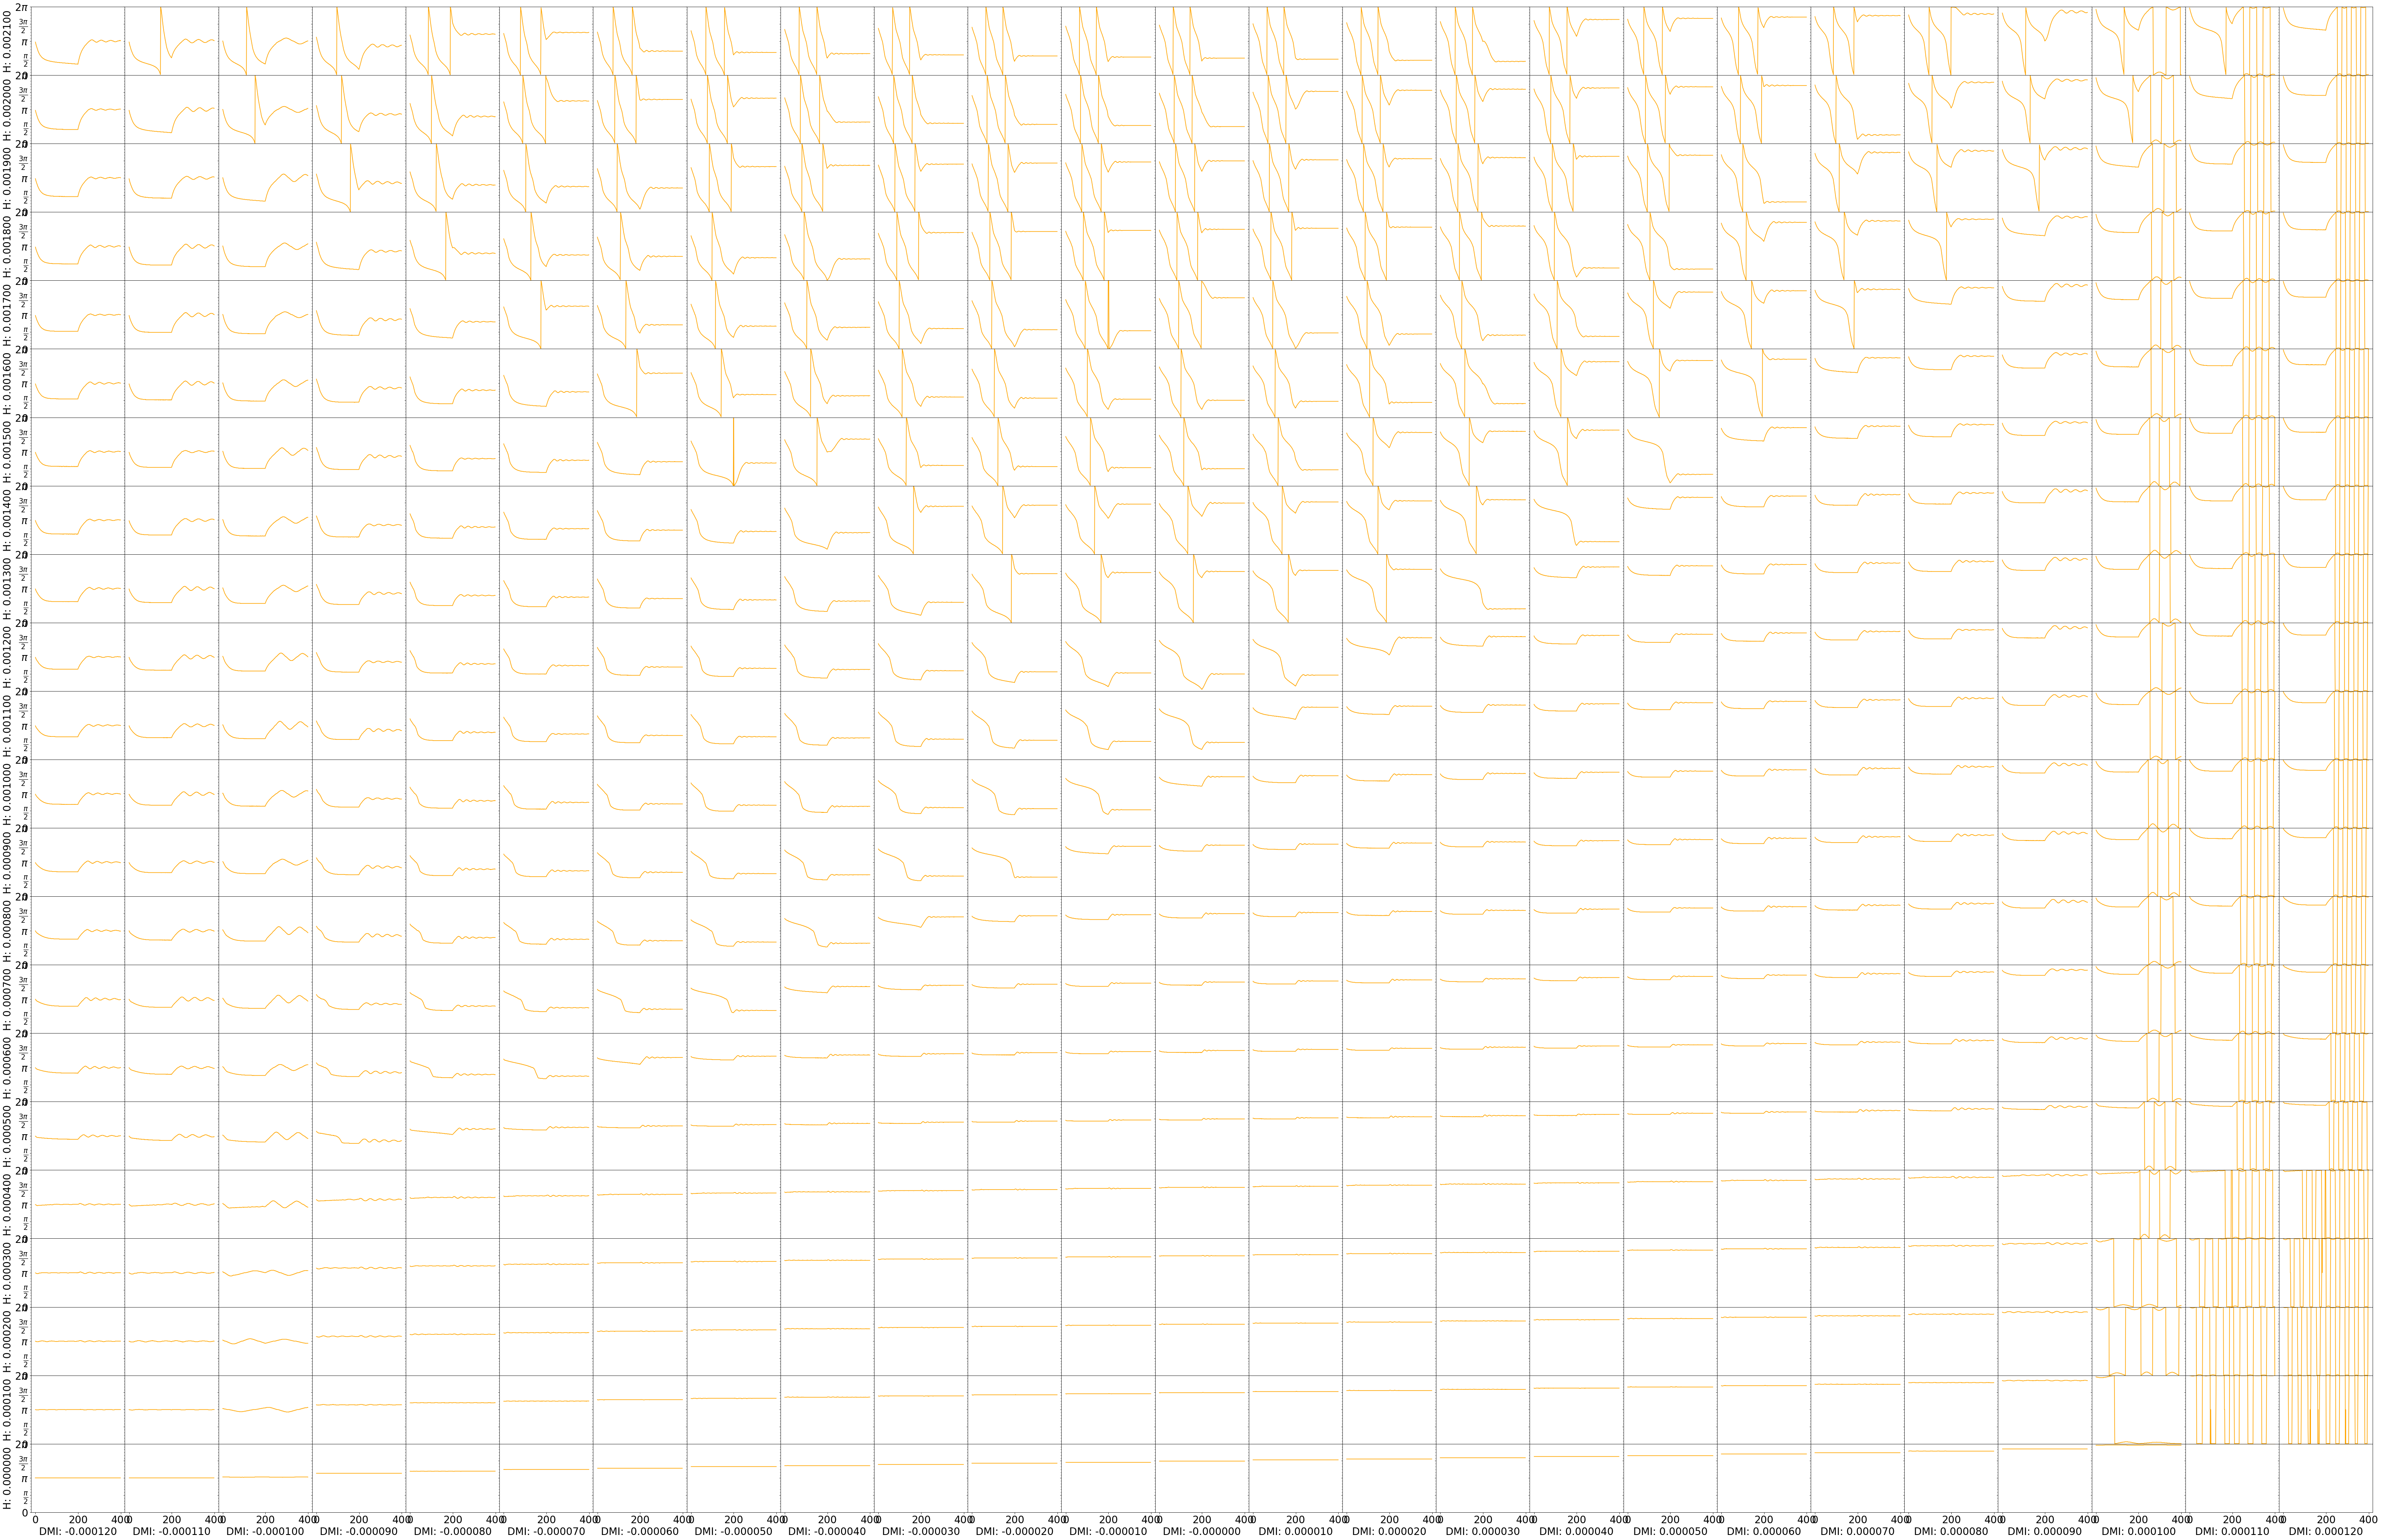

In [ ]:
make_long_grid(df, x=np.unique(df['DMI']), y=np.unique(df['field']))

## Old Visualizations
Unlikely to work with current data conversion method, but maybe it can be helpful

###Draw Single/Comparative Plot

In [ ]:
matplotlib.__version__

'3.2.2'

In [ ]:
#df1 = pd.read_csv("/content/drive/MyDrive/Mumax Data/12-15-thin_wall_b_b1_full.csv")
#df2 = pd.read_csv("/content/drive/MyDrive/Mumax Data/12-15-thick_wall_f_b1_full.csv")
df1 = pd.read_csv("/content/drive/MyDrive/Mumax Data/1-11-thin_wall_d_b1_full.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Mumax Data/1-11-thick_wall_g_b1_full.csv")

In [ ]:
def plot_type_2_plus(x, y, Z, fig_names, Z2, offset=0.5):

    #plt.figure.clf()

    #figure_size = plt.gcf().get_size_inches()
    #factor = (.3, 1.0)
    #plt.gcf().set_size_inches(factor * figure_size)

    fig, ax = plt.subplots()
    #axes = plt.gca()

    #fig.set_figwidth(3)

    ax.set_title('Angle')
    plotted = ax.imshow(np.hstack((Z, Z2)), cmap=newcmp, vmin=0.0, vmax=2*np.pi, origin='upper')
    cb = plt.colorbar(plotted, format=plt.FuncFormatter(multiple_formatter()))
    cb.set_ticks(plt.MultipleLocator(np.pi / 2))
    #plotted = axes.scatter(X,Y, c=Z, marker="s", cmap=newcmp, vmin=0.0, vmax=2*np.pi)
    #axes.scatter(X + offset, Y, c=Z2, marker="s", cmap=newcmp, vmin=0.0, vmax=2*np.pi)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(fig_names)
    #x2, y2 = scaled_xy(x, y)
    ax.set_yticks(np.arange(len(y)))
    print(y)
    ax.set_yticklabels(['%0.2f' % label for label in y])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #axes.tick_params(which='both', size=5)
    ax.invert_yaxis()

    #plt.tight_layout()
    #plt.savefig(fig_name+".png")
    #plt.close(plt.gcf())

In [ ]:
#df1[df1['time']==t]

     Unnamed: 0      DMI   field  b_1       b_2       n_1  n_2     angle  time
399         399 -0.00004  0.0002  0.0  0.532432  0.467568  0.0  4.006576   399
     Unnamed: 0      DMI   field  b_1       b_2       n_1  n_2     angle  time
799         799 -0.00004  0.0004  0.0  0.472458  0.527542  0.0  3.885302   399
      Unnamed: 0      DMI   field       b_1  b_2       n_1  n_2     angle  time
1199        1199 -0.00004  0.0006  0.772186  0.0  0.227814  0.0  1.842032   399
      Unnamed: 0      DMI   field       b_1  ...       n_1       n_2     angle  time
1599        1599 -0.00004  0.0008  0.978918  ...  0.012689  0.008393  1.570809   399

[1 rows x 9 columns]
      Unnamed: 0      DMI  field       b_1  b_2  n_1       n_2     angle  time
1999        1999 -0.00004  0.001  0.710079  0.0  0.0  0.289921  1.189731   399
      Unnamed: 0      DMI   field       b_1  b_2  n_1       n_2     angle  time
2399        2399 -0.00004  0.0012  0.358602  0.0  0.0  0.641398  0.520845   399
      Unnamed:

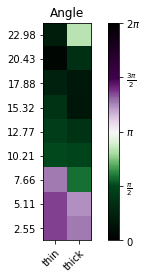

In [ ]:
t = 399
t_df1 = df1[df1['time']==399]
t_df2 = df2[df2['time']==399]

x = np.unique(t_df1['DMI'].values)
y = np.unique(t_df1['field'].values)

x2, y2 = scaled_xy(x, y)

Z1 = np.zeros((len(y), len(x)))
Z2 = np.zeros((len(y), len(x)))

for ind in range(len(t_df1)):
    b_df1 = t_df1.iloc[ind]
    b_df2 = t_df2[t_df2['field']==b_df1['field']]
    b_df2 = b_df2[b_df2['DMI']==b_df1['DMI']]
    j = np.where(y == b_df1['field'])
    i = np.where(x == b_df1['DMI'])
    #print(b_df)
    print(b_df2)
    Z1[j,i] = b_df1['angle']
    Z2[j,i] = b_df2['angle']
print(y)
#["thick", "thin"]

plot_type_2_plus(x2, y2, Z1, ["thin", "thick"], Z2, offset=0.01)


In [ ]:
Z2

array([[4.25039003],
       [4.25039003],
       [4.12719009],
       [1.71247593],
       [1.51535633],
       [1.2935969 ],
       [3.11695271],
       [1.02255741],
       [1.219677  ]])

In [ ]:
ZA = np.zeros((len(y), len(x)))
for i,d in enumerate(x):
    for j,m in enumerate(y):
        ZA[j,i] = full_df[(full_df['DMI']==d) & (full_df['field']==m)]['angle'].values[0]


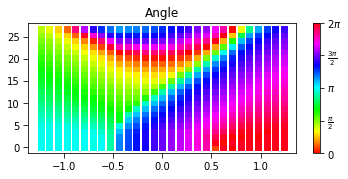

In [ ]:
plt.clf()

figure_size = plt.gcf().get_size_inches()
factor = (1.0, 0.6)
plt.gcf().set_size_inches(factor * figure_size)
axes = plt.gca()

#fig.set_figheight(3)

axes.set_title('Angle')
plotted = axes.scatter(X,Y, c=ZA, marker="s", cmap="hsv", vmin=0.0, vmax=2*np.pi)
axes.tick_params(which='both', size=5)
cb = plt.colorbar(plotted, format=plt.FuncFormatter(multiple_formatter()))
cb.set_ticks(plt.MultipleLocator(np.pi / 2))
#cb.set_ticklabels(['0, PI/2, PI, 3PI/2, 2PI'])
#cb.set_label('angle')

#cb.ax.set_yticklabels()
#set_major_locator(plt.MultipleLocator(np.pi / 2))
#cb.ax.set_minor_locator(plt.MultipleLocator(np.pi / 12))
#cb.ax.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
#plt.tight_layout()

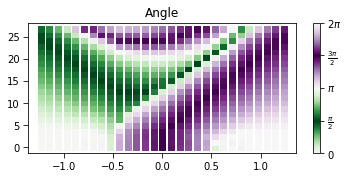

In [ ]:
plt.clf()

figure_size = plt.gcf().get_size_inches()
factor = (1.0, 0.6)
plt.gcf().set_size_inches(factor * figure_size)

axes = plt.gca()

#fig.set_figwidth(3)

axes.set_title('Angle')
plotted = axes.scatter(X,Y, c=ZA, marker="s", cmap=newcmp, vmin=0.0, vmax=2*np.pi)
axes.tick_params(which='both', size=5)
cb = plt.colorbar(plotted, format=plt.FuncFormatter(multiple_formatter()))
cb.set_ticks(plt.MultipleLocator(np.pi / 2))
#plt.tight_layout()

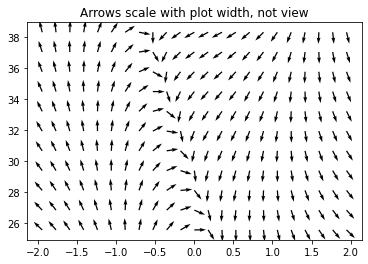

In [ ]:
U = np.cos(ZA)
V = np.sin(ZA)
fig1, ax1 = plt.subplots()
ax1.set_title('Arrows scale with plot width, not view')
Q = ax1.quiver(X, Y, U, V, units='width')
#qk = ax1.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E', coordinates='figure')

####Single Plot

In [ ]:
norm_DMI, Kd = D_crit_and_Kd(A = 10.0e-12, Msat = 8e5, Ku = 12.0e5, tf = 1e-9)
alpha = 0.02
#bza_norm =

In [ ]:
x = np.unique(full_df['DMI'].values/norm_DMI)
y = np.unique((full_df['field'].values/alpha) / bza_norm)
X, Y = np.meshgrid(x,y)

In [ ]:
plt.clf()

figure_size = plt.gcf().get_size_inches()
factor = 4.0
plt.gcf().set_size_inches(factor * figure_size)

#plt.gca().set_aspect('equal')

fig, axes = plt.subplots(2, 2)
#fig.set_figwidth(7)
#fig.set_figheight(6)

#ar = 0.01
axes[0,0].set_title('Bloch CCW')
axes[0,0].scatter(X,Y, c=Z1, marker="s", cmap="Greens")
#axes[0,0].set_aspect(ar)
axes[0,0].tick_params(which='both', size=5)

axes[1,0].set_title('Bloch CW')
axes[1,0].scatter(X,Y, c=Z2, marker="s", cmap="Purples")
#axes[1].set_aspect(ar)
axes[1,0].tick_params(which='both', size=5)

axes[0,1].set_title('Neel Out')
axes[0,1].scatter(X,Y, c=Z3, marker="s", cmap="Blues")
#axes[0,1].set_aspect(ar)
axes[0,1].tick_params(which='both', size=5)

axes[1,1].set_title('Neel In')
axes[1,1].scatter(X,Y, c=Z4, marker="s", cmap="Reds")
#axes[1,1].set_aspect(ar)
axes[1,1].tick_params(which='both', size=5)

#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.grid(False)
#plt.xlabel("common X")
#plt.ylabel("common Y")
for ax in axes.flatten():
    #ax.set_aspect(1.0)
    #ax.set_adjustable(adjustable="datalim")
    ax.set_xlabel('D/Dc')
    ax.set_ylabel('bz/a')

plt.tight_layout()


###Access Single Chirality Plot

In [ ]:
[f for f in os.listdir(os.path.join("/content/drive/MyDrive/Mumax Data/","{}".format(""), 'results'))]
# if f.endswith('.csv')]

In [ ]:
#target parameters

prefix = "FeGd_9-6-wallscan5"
chirality = 'b1'
d = -.10 * 1e-3
B = 0.0005

ds = '{:0.6f}'.format(d)
#print(d)
if d == 0:
    ds = '-'+ds

pre_dir = "m_{}_d_{}_B_{:0.4f}_".format(chirality,ds,B)

access_dir = os.path.join("/content/drive/MyDrive/Mumax Data/",
                          "{}_{}".format(prefix, chirality),
                          "results", pre_dir)





In [ ]:
df_chiral = pd.read_csv(os.path.join(access_dir, pre_dir+"_table.csv"))

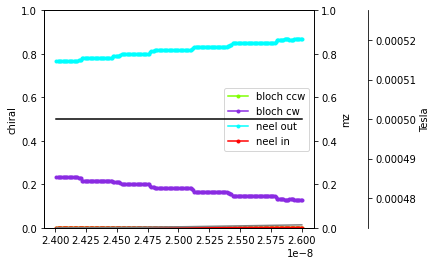

In [ ]:
plot_4_chirality(df_chiral, pre_dir, save=False)

In [ ]:
test_dir = "/content/Test2"
%cd "$test_dir"

/content/Test2


In [ ]:
files = os.listdir()
files.sort()
low_bound = 120
angles = []

for i in range(len(files)):

        #fs = filter(lambda fname: ('m_%03d'%(i)) in fname, files)
        #file = next(fs)
        file = files[i]
        #print(file)

        raw_img, f = chirality_as_hsv(os.path.join(test_dir, file), low_bound=low_bound)

        result = np.stack((raw_img, np.ones_like(raw_img), np.ones_like(raw_img)), axis=-1)

        #Df segment
        #0 - ct, 1 - field, 2 - 3rd var type,4 - 3rd var value, 4 - state

        ind = i

        #segment = data.iloc[ind]

        ###Swap for doing straight conversion only
        #ind = i
        #segment = data.loc[0]

        #B_f = segment['B_extz (T)']
        #Add df entry
        #t_1 = threshold * 0.25
        #total = float(f.sum())
        #print(result.shape)
        #print(f.shape)
        raw_chiral = raw_img *(2*np.pi)
        total_angle = np.median(raw_chiral[f > 0])
        angles.append(total_angle)

In [ ]:
angles

[3.141592653589793,
 3.9547104597012637,
 4.250390028945649,
 4.275029635421479,
 4.299669718734467,
 4.299669718734467,
 4.299669718734467,
 4.299669718734467,
 4.299669718734467,
 4.299669718734467,
 4.311989760390961]

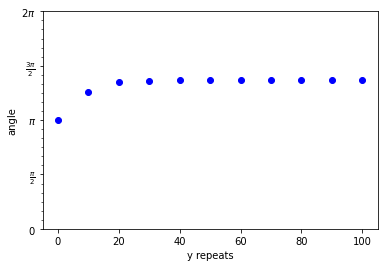

In [ ]:
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
plt.ylim((0, 2*np.pi))
plt.xlabel('y repeats')
plt.ylabel('angle')
plt.plot(np.arange(0, 101, 10), angles, 'bo')

###Access individual image

In [ ]:
len(os.listdir(os.path.join("/content/drive/MyDrive/Mumax Data/",
                              "{}_{}".format(prefix, chirality),
                              pre_dir)))

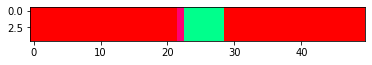

In [ ]:
img_path = os.path.join("/content/drive/MyDrive/Mumax Data/",
                        "{}_{}".format(prefix, chirality),
                        pre_dir, pre_dir+"t_0056"+".png")
res, f = chirality_as_hsv(img_path)
result = np.stack((res*f, np.ones_like(res), np.ones_like(res)), axis=-1)
plt.imshow(colors.hsv_to_rgb(result))

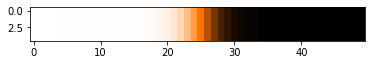

In [ ]:
img = plt.imread(os.path.join("/content/drive/MyDrive/Mumax Data/",
                              "{}_{}".format(prefix, chirality),
                              pre_dir, pre_dir+"t_0056"+".png"
                              ))
plt.imshow(img)